## Core Workflow: Download Sentinel-1 and Sentinel-2 images
Purpose: Search and acquire Sentinel-1 and Sentinel-2 images for a given studay area and time period. The acquired images can be inspected for conditions such as cloud cover, haziness etc. Finally, the acquired images can be downloaded and stored in the path.
<br>
Requirements: This notebook uses `bronco.py` and `bronco_candidates.py`
<br>
<br>
*Date: 2018-09-12*
<br>
*Author: Taufiq Rashid*


### Import statements

In [1]:
# typical, comprehensive imports


import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

sys.path.append('/home/Taufiq.Rashid/UrbanLandUse/utils')
print sys.path

import bronco
import bronco_candidates
reload(bronco)
reload(bronco_candidates)

Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Taufiq.Rashid/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Taufiq.Rashid/UrbanLandUse/utils']


<module 'bronco_candidates' from '/home/Taufiq.Rashid/UrbanLandUse/utils/bronco_candidates.pyc'>

### Set key variables

In [2]:
place = 'hyderabad'  # setting the study area

data_root='/data/phase_iii/'
data_path=data_root+place+'/'  

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'  
s1_resolution = 10  

### Load and inspect study area 

hyderabad Hyderabad
>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/phase_iii/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/phase_iii/hyderabad/Hyderabad_studyAreaEPSG4326.shp
INFO: Open of `/data

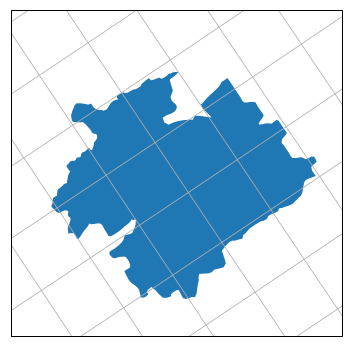

In [3]:
print place, place.title()  # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

bronco_candidates.info_studyareas(data_path, place)

shape = bronco_candidates.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
bbox = shape['bbox']

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (bbox[0]+bbox[2])/2.0, (bbox[1]+bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile000 {u'type': u'Polygon', u'coordinates': [[[78.13077314139645, 17.436029491683943], [78.15785947221487, 17.43641812209065], [78.15745617371114, 17.46241865708724], [78.13036601215559, 17.462029411047467], [78.13077314139645, 17.436029491683943]]]}


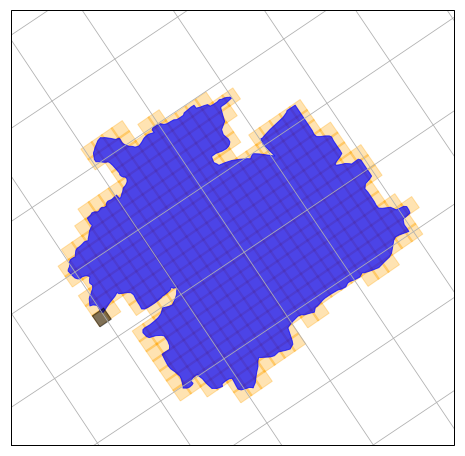

In [4]:
single_tile_id = 22
tiles = dl.raster.dltiles_from_shape(10.0, 256, 16, shape) 
bronco_candidates.draw_tiled_area(shape, tiles, albers, lonlat_crs)

### Search and acquire sentinel-2 imagery 

In [5]:
product = u'sentinel-2:L1C'
satellite='S2A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2016-10-01', end_time='2017-11-01', 
                                        cloud_fraction_0=0.5, limit=75, geom=shape['geometry'])
s2_ids = [f['id'] for f in feature_collection['features']]
s2_ids.sort()
print len(s2_ids), s2_ids


54 [u'sentinel-2:L1C:2016-10-06_43QHV_58_S2A_v1', u'sentinel-2:L1C:2016-10-16_43QHV_96_S2A_v1', u'sentinel-2:L1C:2016-10-16_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-10-26_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-10-26_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-10-29_43QHV_30_S2A_v1', u'sentinel-2:L1C:2016-11-05_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-11-05_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-11-15_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-11-15_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-11-25_43QHV_98_S2A_v1', u'sentinel-2:L1C:2016-11-25_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-05_43QHV_98_S2A_v1', u'sentinel-2:L1C:2016-12-05_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-15_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-15_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-25_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-25_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-28_43QHV_30_S2A_v1', u'sentinel-2:L1C:2017-01-04_43QHV_38_S2A_v1', u'sentinel-2:L1C:2017-01-04_44QKE_48_S2A_v1', u'sentinel-2:L1C:2017-01-07_43

### View image extents

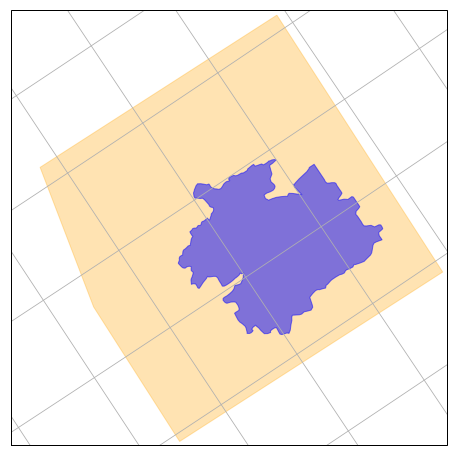

In [6]:
s2_imgs = s2_ids[6:7]

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

shapes = []
for s2_img in s2_imgs:
    metadata = dl.metadata.get(s2_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')
ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
bbox = union.bounds
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()


### Inspect imagery

[u'sentinel-2:L1C:2016-11-05_43QHV_97_S2A_v1'] (787, 841, 4)


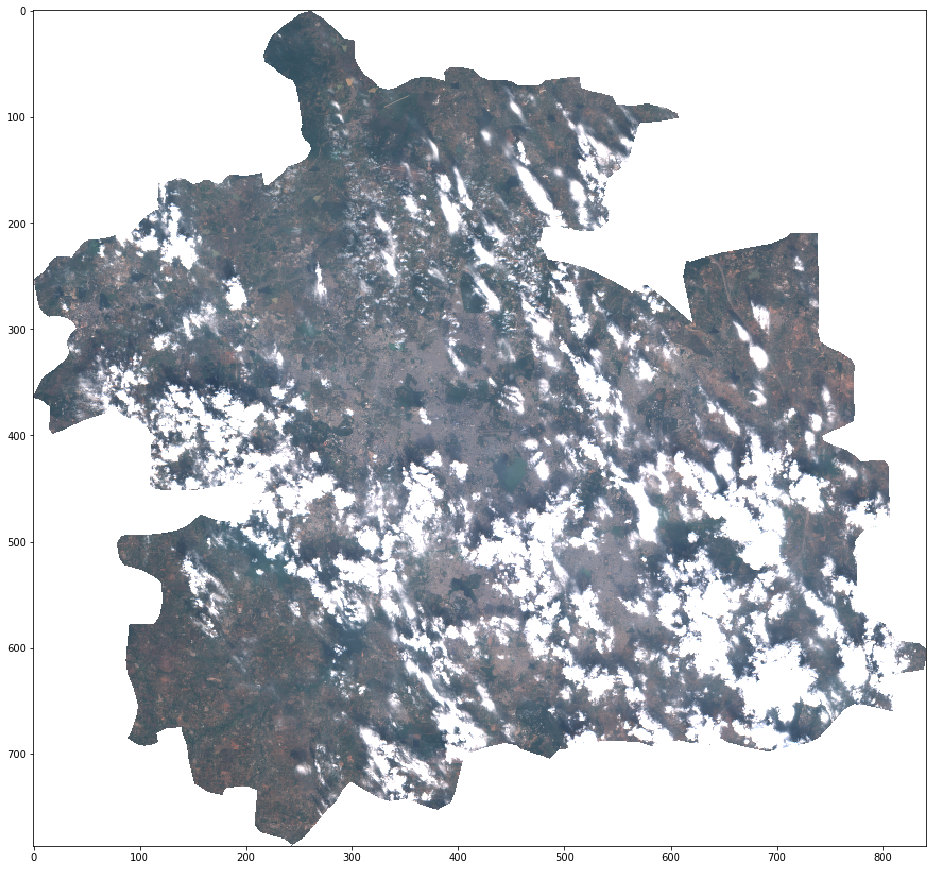

In [7]:
bronco.show_scene(s2_imgs[:],bands=['red','green','blue','alpha'],scales=[[0,3000],[0,3000],[0,3000],], geom=shape['geometry'], resolution=80)

### Download imagery 


In [21]:
# pull from api and save to file tiled images: sentinel-2 vir
s2_dict = {}
#s2_dict['O'] = [u'sentinel-2:L1C:2017-05-14_43QHV_98_S2A_v1'] 
#s2_dict['P'] = [u'sentinel-2:L1C:2017-11-10_43QHV_56_S2A_v1', u'sentinel-2:L1C:2017-11-10_43QHV_58_S2A_v1'] 
#s2_dict['Q'] = [u'sentinel-2:L1C:2017-11-30_43QHV_97_S2A_v1']
#s2_dict['R'] = [u'sentinel-2:L1C:2017-12-15_43QHV_97_S2B_v1']
#s2_dict['S'] = [u'sentinel-2:L1C:2017-12-20_43QHV_97_S2A_v1']
#s2_dict['T'] = [u'sentinel-2:L1C:2017-12-25_43QHV_97_S2B_v1']
#s2_dict['U'] = [u'sentinel-2:L1C:2018-01-04_43QHV_97_S2B_v1']
#s2_dict['V'] = [u'sentinel-2:L1C:2018-01-14_43QHV_97_S2B_v1']
#s2_dict['W'] = [u'sentinel-2:L1C:2018-01-24_43QHV_97_S2B_v1'] 
#s2_dict['X'] = [u'sentinel-2:L1C:2018-01-29_43QHV_97_S2A_v1']
#s2_dict['Y'] = [u'sentinel-2:L1C:2018-02-03_43QHV_97_S2B_v1']
#s2_dict['Z'] = [u'sentinel-2:L1C:2018-02-08_43QHV_97_S2A_v1']
#s2_dict['AA'] = [u'sentinel-2:L1C:2018-02-18_43QHV_97_S2A_v1']
#s2_dict['AB'] = [u'sentinel-2:L1C:2018-02-23_43QHV_97_S2B_v1']
#s2_dict['AC'] = [u'sentinel-2:L1C:2018-02-28_43QHV_97_S2A_v1']
#s2_dict['AD'] = [u'sentinel-2:L1C:2018-03-05_43QHV_97_S2B_v1'] 
#s2_dict['AE'] = [u'sentinel-2:L1C:2018-03-10_43QHV_97_S2A_v1']
#s2_dict['AF'] = [u'sentinel-2:L1C:2018-03-25_43QHV_97_S2B_v1']
#s2_dict['AG'] = [u'sentinel-2:L1C:2018-03-30_43QHV_97_S2A_v1']
#s2_dict['AH'] = [u'sentinel-2:L1C:2018-04-04_43QHV_97_S2B_v1']
#s2_dict['AI'] = [u'sentinel-2:L1C:2018-04-09_43QHV_97_S2A_v1']
#s2_dict['AJ'] = [u'sentinel-2:L1C:2018-04-14_43QHV_97_S2B_v1'] 
#s2_dict['AK'] = [u'sentinel-2:L1C:2018-04-24_43QHV_97_S2B_v1'] 
#s2_dict['AL'] = [u'sentinel-2:L1C:2018-04-29_43QHV_97_S2A_v1']
#s2_dict['AM'] = [u'sentinel-2:L1C:2018-05-09_43QHV_97_S2A_v1']
#s2_dict['AN'] = [u'sentinel-2:L1C:2018-05-14_43QHV_97_S2B_v1']
#s2_dict['AO'] = [u'sentinel-2:L1C:2018-05-19_43QHV_97_S2A_v1']
#s2_dict['AP'] = [u'sentinel-2:L1C:2018-05-29_43QHV_97_S2A_v1']
#s2_dict['AQ'] = [u'sentinel-2:L1C:2018-09-11_43QHV_97_S2B_v1'] 


continue_index = 0

for vir_suffix, s2_imgs in s2_dict.iteritems():
    print vir_suffix, s2_imgs
    continue_index = 0

    for tile_id in range(len(tiles['features'])):
        if (tile_id < continue_index):
            print 'tile', tile_id, 'continuing'
            continue
        tile = tiles['features'][tile_id]
        print 'tile', tile_id, 'download VIR image'
        vir_band_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_vir_'+vir_suffix
        print vir_band_file
        vir = dl.raster.raster(
                s2_imgs,
                bands=bands,
                data_type='UInt16',
                dltile=tile,
                cutline=shape['geometry'],
                save=True,
                outfile_basename=vir_band_file)

AA [u'sentinel-2:L1C:2018-02-18_43QHV_97_S2A_v1']
tile 0 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile000_vir_AA
tile 1 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile001_vir_AA
tile 2 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile002_vir_AA
tile 3 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile003_vir_AA
tile 4 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile004_vir_AA
tile 5 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile005_vir_AA
tile 6 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile006_vir_AA
tile 7 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile007_vir_AA
tile 8 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile008_vir_AA
tile 9 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile009_vir_AA
tile 10 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile010_vir_AA
tile 11 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile011_vir_AA
tile 12 download VIR ima

tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105_vir_AA
tile 106 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile106_vir_AA
tile 107 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile107_vir_AA
tile 108 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile108_vir_AA
tile 109 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile109_vir_AA
tile 110 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile110_vir_AA
tile 111 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile111_vir_AA
tile 112 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile112_vir_AA
tile 113 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile113_vir_AA
tile 114 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile114_vir_AA
tile 115 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile115_vir_AA
tile 116 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile116_vir_AA
tile 117 download VIR image
/data/phase_iii/hyderaba

tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_AA
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_AA
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile211_vir_AA
tile 212 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile212_vir_AA
tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_AA
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile214_vir_AA
tile 215 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile215_vir_AA
tile 216 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile216_vir_AA
tile 217 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile217_vir_AA
tile 218 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile218_vir_AA
tile 219 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile219_vir_AA
tile 220 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile220_vir_AA
tile 221 download VIR image
/data/phase_iii/hyderaba

tile 313 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile313_vir_AA
tile 314 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile314_vir_AA
tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_AA
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_AA
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_AA
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_AA
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_AA
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile320_vir_AA
tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile321_vir_AA
tile 322 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile322_vir_AA
tile 323 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile323_vir_AA
tile 324 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile324_vir_AA
tile 325 download VIR image
/data/phase_iii/hyderaba

tile 417 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile417_vir_AA
tile 418 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile418_vir_AA
tile 419 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile419_vir_AA
tile 420 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile420_vir_AA
tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_AA
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_AA
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_AA
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_AA
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_AA
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_AA
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile427_vir_AA
tile 428 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile428_vir_AA
tile 429 download VIR image
/data/phase_iii/hyderaba

tile 63 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile063_vir_AC
tile 64 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile064_vir_AC
tile 65 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile065_vir_AC
tile 66 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile066_vir_AC
tile 67 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile067_vir_AC
tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_AC
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_AC
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_AC
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_AC
tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_AC
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile073_vir_AC
tile 74 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile074_vir_AC
tile 75 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 168 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile168_vir_AC
tile 169 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile169_vir_AC
tile 170 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile170_vir_AC
tile 171 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile171_vir_AC
tile 172 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile172_vir_AC
tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_AC
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_AC
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_AC
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_AC
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_AC
tile 178 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile178_vir_AC
tile 179 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile179_vir_AC
tile 180 download VIR image
/data/phase_iii/hyderaba

tile 272 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile272_vir_AC
tile 273 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile273_vir_AC
tile 274 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile274_vir_AC
tile 275 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile275_vir_AC
tile 276 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile276_vir_AC
tile 277 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile277_vir_AC
tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_AC
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_AC
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_AC
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_AC
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_AC
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile283_vir_AC
tile 284 download VIR image
/data/phase_iii/hyderaba

tile 376 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile376_vir_AC
tile 377 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile377_vir_AC
tile 378 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile378_vir_AC
tile 379 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile379_vir_AC
tile 380 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile380_vir_AC
tile 381 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile381_vir_AC
tile 382 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile382_vir_AC
tile 383 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile383_vir_AC
tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_AC
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_AC
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_AC
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_AC
tile 388 download VIR image
/data/phase_iii/hyderaba

tile 22 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile022_vir_AB
tile 23 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile023_vir_AB
tile 24 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile024_vir_AB
tile 25 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile025_vir_AB
tile 26 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile026_vir_AB
tile 27 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile027_vir_AB
tile 28 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile028_vir_AB
tile 29 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile029_vir_AB
tile 30 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile030_vir_AB
tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_AB
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_AB
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_AB
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 127 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile127_vir_AB
tile 128 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile128_vir_AB
tile 129 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile129_vir_AB
tile 130 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile130_vir_AB
tile 131 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile131_vir_AB
tile 132 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile132_vir_AB
tile 133 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile133_vir_AB
tile 134 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile134_vir_AB
tile 135 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile135_vir_AB
tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_AB
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_AB
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_AB
tile 139 download VIR image
/data/phase_iii/hyderaba

tile 231 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile231_vir_AB
tile 232 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile232_vir_AB
tile 233 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile233_vir_AB
tile 234 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile234_vir_AB
tile 235 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile235_vir_AB
tile 236 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile236_vir_AB
tile 237 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile237_vir_AB
tile 238 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile238_vir_AB
tile 239 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile239_vir_AB
tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_AB
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_AB
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_AB
tile 243 download VIR image
/data/phase_iii/hyderaba

tile 335 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile335_vir_AB
tile 336 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile336_vir_AB
tile 337 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile337_vir_AB
tile 338 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile338_vir_AB
tile 339 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile339_vir_AB
tile 340 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile340_vir_AB
tile 341 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile341_vir_AB
tile 342 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile342_vir_AB
tile 343 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile343_vir_AB
tile 344 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile344_vir_AB
tile 345 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile345_vir_AB
tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_AB
tile 347 download VIR image
/data/phase_iii/hyderaba

tile 439 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile439_vir_AB
tile 440 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile440_vir_AB
tile 441 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile441_vir_AB
tile 442 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile442_vir_AB
tile 443 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile443_vir_AB
tile 444 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile444_vir_AB
tile 445 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile445_vir_AB
tile 446 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile446_vir_AB
tile 447 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile447_vir_AB
tile 448 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile448_vir_AB
tile 449 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile449_vir_AB
tile 450 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile450_vir_AB
tile 451 download VIR image
/data/phase_iii/hyderaba

tile 86 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile086_vir_AE
tile 87 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile087_vir_AE
tile 88 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile088_vir_AE
tile 89 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile089_vir_AE
tile 90 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile090_vir_AE
tile 91 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile091_vir_AE
tile 92 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile092_vir_AE
tile 93 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile093_vir_AE
tile 94 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile094_vir_AE
tile 95 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile095_vir_AE
tile 96 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile096_vir_AE
tile 97 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile097_vir_AE
tile 98 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 190 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile190_vir_AE
tile 191 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile191_vir_AE
tile 192 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile192_vir_AE
tile 193 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile193_vir_AE
tile 194 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile194_vir_AE
tile 195 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile195_vir_AE
tile 196 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile196_vir_AE
tile 197 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile197_vir_AE
tile 198 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile198_vir_AE
tile 199 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile199_vir_AE
tile 200 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile200_vir_AE
tile 201 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile201_vir_AE
tile 202 download VIR image
/data/phase_iii/hyderaba

tile 294 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile294_vir_AE
tile 295 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile295_vir_AE
tile 296 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile296_vir_AE
tile 297 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile297_vir_AE
tile 298 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile298_vir_AE
tile 299 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile299_vir_AE
tile 300 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile300_vir_AE
tile 301 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile301_vir_AE
tile 302 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile302_vir_AE
tile 303 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile303_vir_AE
tile 304 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile304_vir_AE
tile 305 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile305_vir_AE
tile 306 download VIR image
/data/phase_iii/hyderaba

tile 398 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile398_vir_AE
tile 399 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile399_vir_AE
tile 400 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile400_vir_AE
tile 401 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile401_vir_AE
tile 402 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile402_vir_AE
tile 403 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile403_vir_AE
tile 404 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile404_vir_AE
tile 405 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile405_vir_AE
tile 406 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile406_vir_AE
tile 407 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile407_vir_AE
tile 408 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile408_vir_AE
tile 409 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile409_vir_AE
tile 410 download VIR image
/data/phase_iii/hyderaba

tile 44 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile044_vir_AD
tile 45 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile045_vir_AD
tile 46 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile046_vir_AD
tile 47 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile047_vir_AD
tile 48 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile048_vir_AD
tile 49 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile049_vir_AD
tile 50 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile050_vir_AD
tile 51 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile051_vir_AD
tile 52 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile052_vir_AD
tile 53 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile053_vir_AD
tile 54 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile054_vir_AD
tile 55 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile055_vir_AD
tile 56 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 149 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile149_vir_AD
tile 150 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile150_vir_AD
tile 151 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile151_vir_AD
tile 152 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile152_vir_AD
tile 153 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile153_vir_AD
tile 154 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile154_vir_AD
tile 155 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile155_vir_AD
tile 156 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile156_vir_AD
tile 157 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile157_vir_AD
tile 158 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile158_vir_AD
tile 159 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile159_vir_AD
tile 160 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile160_vir_AD
tile 161 download VIR image
/data/phase_iii/hyderaba

tile 253 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile253_vir_AD
tile 254 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile254_vir_AD
tile 255 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile255_vir_AD
tile 256 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile256_vir_AD
tile 257 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile257_vir_AD
tile 258 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile258_vir_AD
tile 259 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile259_vir_AD
tile 260 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile260_vir_AD
tile 261 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile261_vir_AD
tile 262 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile262_vir_AD
tile 263 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile263_vir_AD
tile 264 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile264_vir_AD
tile 265 download VIR image
/data/phase_iii/hyderaba

tile 357 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile357_vir_AD
tile 358 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile358_vir_AD
tile 359 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile359_vir_AD
tile 360 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile360_vir_AD
tile 361 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile361_vir_AD
tile 362 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile362_vir_AD
tile 363 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile363_vir_AD
tile 364 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile364_vir_AD
tile 365 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile365_vir_AD
tile 366 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile366_vir_AD
tile 367 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile367_vir_AD
tile 368 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile368_vir_AD
tile 369 download VIR image
/data/phase_iii/hyderaba

tile 3 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile003_vir_AG
tile 4 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile004_vir_AG
tile 5 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile005_vir_AG
tile 6 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile006_vir_AG
tile 7 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile007_vir_AG
tile 8 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile008_vir_AG
tile 9 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile009_vir_AG
tile 10 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile010_vir_AG
tile 11 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile011_vir_AG
tile 12 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile012_vir_AG
tile 13 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile013_vir_AG
tile 14 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile014_vir_AG
tile 15 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile015_

tile 109 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile109_vir_AG
tile 110 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile110_vir_AG
tile 111 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile111_vir_AG
tile 112 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile112_vir_AG
tile 113 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile113_vir_AG
tile 114 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile114_vir_AG
tile 115 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile115_vir_AG
tile 116 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile116_vir_AG
tile 117 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile117_vir_AG
tile 118 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile118_vir_AG
tile 119 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile119_vir_AG
tile 120 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile120_vir_AG
tile 121 download VIR image
/data/phase_iii/hyderaba

tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_AG
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile214_vir_AG
tile 215 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile215_vir_AG
tile 216 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile216_vir_AG
tile 217 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile217_vir_AG
tile 218 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile218_vir_AG
tile 219 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile219_vir_AG
tile 220 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile220_vir_AG
tile 221 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile221_vir_AG
tile 222 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile222_vir_AG
tile 223 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile223_vir_AG
tile 224 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile224_vir_AG
tile 225 download VIR image
/data/phase_iii/hyderaba

tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_AG
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_AG
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_AG
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile320_vir_AG
tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile321_vir_AG
tile 322 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile322_vir_AG
tile 323 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile323_vir_AG
tile 324 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile324_vir_AG
tile 325 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile325_vir_AG
tile 326 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile326_vir_AG
tile 327 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile327_vir_AG
tile 328 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile328_vir_AG
tile 329 download VIR image
/data/phase_iii/hyderaba

tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_AG
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_AG
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_AG
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_AG
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_AG
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_AG
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile427_vir_AG
tile 428 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile428_vir_AG
tile 429 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile429_vir_AG
tile 430 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile430_vir_AG
tile 431 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile431_vir_AG
tile 432 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile432_vir_AG
tile 433 download VIR image
/data/phase_iii/hyderaba

tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_AF
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_AF
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_AF
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_AF
tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_AF
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile073_vir_AF
tile 74 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile074_vir_AF
tile 75 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile075_vir_AF
tile 76 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile076_vir_AF
tile 77 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile077_vir_AF
tile 78 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile078_vir_AF
tile 79 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile079_vir_AF
tile 80 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_AF
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_AF
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_AF
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_AF
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_AF
tile 178 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile178_vir_AF
tile 179 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile179_vir_AF
tile 180 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile180_vir_AF
tile 181 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile181_vir_AF
tile 182 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile182_vir_AF
tile 183 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile183_vir_AF
tile 184 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile184_vir_AF
tile 185 download VIR image
/data/phase_iii/hyderaba

tile 277 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile277_vir_AF
tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_AF
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_AF
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_AF
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_AF
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_AF
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile283_vir_AF
tile 284 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile284_vir_AF
tile 285 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile285_vir_AF
tile 286 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile286_vir_AF
tile 287 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile287_vir_AF
tile 288 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile288_vir_AF
tile 289 download VIR image
/data/phase_iii/hyderaba

tile 381 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile381_vir_AF
tile 382 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile382_vir_AF
tile 383 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile383_vir_AF
tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_AF
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_AF
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_AF
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_AF
tile 388 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile388_vir_AF
tile 389 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile389_vir_AF
tile 390 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile390_vir_AF
tile 391 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile391_vir_AF
tile 392 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile392_vir_AF
tile 393 download VIR image
/data/phase_iii/hyderaba

tile 27 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile027_vir_AI
tile 28 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile028_vir_AI
tile 29 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile029_vir_AI
tile 30 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile030_vir_AI
tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_AI
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_AI
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_AI
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile034_vir_AI
tile 35 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile035_vir_AI
tile 36 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile036_vir_AI
tile 37 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile037_vir_AI
tile 38 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile038_vir_AI
tile 39 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 132 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile132_vir_AI
tile 133 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile133_vir_AI
tile 134 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile134_vir_AI
tile 135 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile135_vir_AI
tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_AI
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_AI
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_AI
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile139_vir_AI
tile 140 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile140_vir_AI
tile 141 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile141_vir_AI
tile 142 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile142_vir_AI
tile 143 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile143_vir_AI
tile 144 download VIR image
/data/phase_iii/hyderaba

tile 236 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile236_vir_AI
tile 237 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile237_vir_AI
tile 238 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile238_vir_AI
tile 239 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile239_vir_AI
tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_AI
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_AI
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_AI
tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_AI
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_AI
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile245_vir_AI
tile 246 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile246_vir_AI
tile 247 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile247_vir_AI
tile 248 download VIR image
/data/phase_iii/hyderaba

tile 340 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile340_vir_AI
tile 341 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile341_vir_AI
tile 342 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile342_vir_AI
tile 343 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile343_vir_AI
tile 344 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile344_vir_AI
tile 345 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile345_vir_AI
tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_AI
tile 347 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile347_vir_AI
tile 348 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile348_vir_AI
tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_AI
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_AI
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile351_vir_AI
tile 352 download VIR image
/data/phase_iii/hyderaba

tile 444 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile444_vir_AI
tile 445 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile445_vir_AI
tile 446 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile446_vir_AI
tile 447 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile447_vir_AI
tile 448 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile448_vir_AI
tile 449 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile449_vir_AI
tile 450 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile450_vir_AI
tile 451 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile451_vir_AI
tile 452 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile452_vir_AI
tile 453 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile453_vir_AI
tile 454 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile454_vir_AI
tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_AI
tile 456 download VIR image
/data/phase_iii/hyderaba

tile 91 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile091_vir_AH
tile 92 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile092_vir_AH
tile 93 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile093_vir_AH
tile 94 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile094_vir_AH
tile 95 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile095_vir_AH
tile 96 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile096_vir_AH
tile 97 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile097_vir_AH
tile 98 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile098_vir_AH
tile 99 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile099_vir_AH
tile 100 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile100_vir_AH
tile 101 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile101_vir_AH
tile 102 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile102_vir_AH
tile 103 download VIR image
/data/phase_iii/hyderabad/hyderab

tile 195 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile195_vir_AH
tile 196 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile196_vir_AH
tile 197 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile197_vir_AH
tile 198 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile198_vir_AH
tile 199 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile199_vir_AH
tile 200 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile200_vir_AH
tile 201 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile201_vir_AH
tile 202 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile202_vir_AH
tile 203 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile203_vir_AH
tile 204 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile204_vir_AH
tile 205 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile205_vir_AH
tile 206 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile206_vir_AH
tile 207 download VIR image
/data/phase_iii/hyderaba

tile 299 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile299_vir_AH
tile 300 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile300_vir_AH
tile 301 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile301_vir_AH
tile 302 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile302_vir_AH
tile 303 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile303_vir_AH
tile 304 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile304_vir_AH
tile 305 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile305_vir_AH
tile 306 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile306_vir_AH
tile 307 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile307_vir_AH
tile 308 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile308_vir_AH
tile 309 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile309_vir_AH
tile 310 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile310_vir_AH
tile 311 download VIR image
/data/phase_iii/hyderaba

tile 403 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile403_vir_AH
tile 404 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile404_vir_AH
tile 405 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile405_vir_AH
tile 406 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile406_vir_AH
tile 407 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile407_vir_AH
tile 408 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile408_vir_AH
tile 409 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile409_vir_AH
tile 410 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile410_vir_AH
tile 411 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile411_vir_AH
tile 412 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile412_vir_AH
tile 413 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile413_vir_AH
tile 414 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile414_vir_AH
tile 415 download VIR image
/data/phase_iii/hyderaba

tile 49 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile049_vir_AK
tile 50 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile050_vir_AK
tile 51 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile051_vir_AK
tile 52 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile052_vir_AK
tile 53 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile053_vir_AK
tile 54 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile054_vir_AK
tile 55 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile055_vir_AK
tile 56 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile056_vir_AK
tile 57 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile057_vir_AK
tile 58 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile058_vir_AK
tile 59 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile059_vir_AK
tile 60 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile060_vir_AK
tile 61 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 154 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile154_vir_AK
tile 155 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile155_vir_AK
tile 156 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile156_vir_AK
tile 157 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile157_vir_AK
tile 158 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile158_vir_AK
tile 159 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile159_vir_AK
tile 160 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile160_vir_AK
tile 161 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile161_vir_AK
tile 162 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile162_vir_AK
tile 163 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile163_vir_AK
tile 164 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile164_vir_AK
tile 165 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile165_vir_AK
tile 166 download VIR image
/data/phase_iii/hyderaba

tile 258 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile258_vir_AK
tile 259 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile259_vir_AK
tile 260 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile260_vir_AK
tile 261 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile261_vir_AK
tile 262 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile262_vir_AK
tile 263 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile263_vir_AK
tile 264 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile264_vir_AK
tile 265 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile265_vir_AK
tile 266 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile266_vir_AK
tile 267 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile267_vir_AK
tile 268 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile268_vir_AK
tile 269 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile269_vir_AK
tile 270 download VIR image
/data/phase_iii/hyderaba

tile 362 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile362_vir_AK
tile 363 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile363_vir_AK
tile 364 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile364_vir_AK
tile 365 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile365_vir_AK
tile 366 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile366_vir_AK
tile 367 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile367_vir_AK
tile 368 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile368_vir_AK
tile 369 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile369_vir_AK
tile 370 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile370_vir_AK
tile 371 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile371_vir_AK
tile 372 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile372_vir_AK
tile 373 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile373_vir_AK
tile 374 download VIR image
/data/phase_iii/hyderaba

tile 8 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile008_vir_AJ
tile 9 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile009_vir_AJ
tile 10 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile010_vir_AJ
tile 11 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile011_vir_AJ
tile 12 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile012_vir_AJ
tile 13 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile013_vir_AJ
tile 14 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile014_vir_AJ
tile 15 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile015_vir_AJ
tile 16 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile016_vir_AJ
tile 17 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile017_vir_AJ
tile 18 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile018_vir_AJ
tile 19 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile019_vir_AJ
tile 20 download VIR image
/data/phase_iii/hyderabad/hyderabad_til

tile 113 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile113_vir_AJ
tile 114 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile114_vir_AJ
tile 115 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile115_vir_AJ
tile 116 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile116_vir_AJ
tile 117 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile117_vir_AJ
tile 118 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile118_vir_AJ
tile 119 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile119_vir_AJ
tile 120 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile120_vir_AJ
tile 121 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile121_vir_AJ
tile 122 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile122_vir_AJ
tile 123 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile123_vir_AJ
tile 124 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile124_vir_AJ
tile 125 download VIR image
/data/phase_iii/hyderaba

tile 217 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile217_vir_AJ
tile 218 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile218_vir_AJ
tile 219 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile219_vir_AJ
tile 220 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile220_vir_AJ
tile 221 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile221_vir_AJ
tile 222 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile222_vir_AJ
tile 223 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile223_vir_AJ
tile 224 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile224_vir_AJ
tile 225 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile225_vir_AJ
tile 226 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile226_vir_AJ
tile 227 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile227_vir_AJ
tile 228 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile228_vir_AJ
tile 229 download VIR image
/data/phase_iii/hyderaba

tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile321_vir_AJ
tile 322 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile322_vir_AJ
tile 323 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile323_vir_AJ
tile 324 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile324_vir_AJ
tile 325 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile325_vir_AJ
tile 326 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile326_vir_AJ
tile 327 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile327_vir_AJ
tile 328 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile328_vir_AJ
tile 329 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile329_vir_AJ
tile 330 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile330_vir_AJ
tile 331 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile331_vir_AJ
tile 332 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile332_vir_AJ
tile 333 download VIR image
/data/phase_iii/hyderaba

tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_AJ
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_AJ
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile427_vir_AJ
tile 428 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile428_vir_AJ
tile 429 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile429_vir_AJ
tile 430 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile430_vir_AJ
tile 431 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile431_vir_AJ
tile 432 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile432_vir_AJ
tile 433 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile433_vir_AJ
tile 434 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile434_vir_AJ
tile 435 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile435_vir_AJ
tile 436 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile436_vir_AJ
tile 437 download VIR image
/data/phase_iii/hyderaba

tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_AM
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile073_vir_AM
tile 74 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile074_vir_AM
tile 75 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile075_vir_AM
tile 76 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile076_vir_AM
tile 77 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile077_vir_AM
tile 78 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile078_vir_AM
tile 79 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile079_vir_AM
tile 80 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile080_vir_AM
tile 81 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile081_vir_AM
tile 82 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile082_vir_AM
tile 83 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile083_vir_AM
tile 84 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_AM
tile 178 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile178_vir_AM
tile 179 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile179_vir_AM
tile 180 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile180_vir_AM
tile 181 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile181_vir_AM
tile 182 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile182_vir_AM
tile 183 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile183_vir_AM
tile 184 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile184_vir_AM
tile 185 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile185_vir_AM
tile 186 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile186_vir_AM
tile 187 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile187_vir_AM
tile 188 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile188_vir_AM
tile 189 download VIR image
/data/phase_iii/hyderaba

tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_AM
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_AM
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile283_vir_AM
tile 284 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile284_vir_AM
tile 285 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile285_vir_AM
tile 286 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile286_vir_AM
tile 287 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile287_vir_AM
tile 288 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile288_vir_AM
tile 289 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile289_vir_AM
tile 290 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile290_vir_AM
tile 291 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile291_vir_AM
tile 292 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile292_vir_AM
tile 293 download VIR image
/data/phase_iii/hyderaba

tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_AM
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_AM
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_AM
tile 388 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile388_vir_AM
tile 389 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile389_vir_AM
tile 390 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile390_vir_AM
tile 391 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile391_vir_AM
tile 392 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile392_vir_AM
tile 393 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile393_vir_AM
tile 394 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile394_vir_AM
tile 395 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile395_vir_AM
tile 396 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile396_vir_AM
tile 397 download VIR image
/data/phase_iii/hyderaba

tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_AL
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_AL
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_AL
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile034_vir_AL
tile 35 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile035_vir_AL
tile 36 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile036_vir_AL
tile 37 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile037_vir_AL
tile 38 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile038_vir_AL
tile 39 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile039_vir_AL
tile 40 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile040_vir_AL
tile 41 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile041_vir_AL
tile 42 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile042_vir_AL
tile 43 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_AL
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_AL
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_AL
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile139_vir_AL
tile 140 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile140_vir_AL
tile 141 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile141_vir_AL
tile 142 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile142_vir_AL
tile 143 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile143_vir_AL
tile 144 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile144_vir_AL
tile 145 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile145_vir_AL
tile 146 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile146_vir_AL
tile 147 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile147_vir_AL
tile 148 download VIR image
/data/phase_iii/hyderaba

tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_AL
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_AL
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_AL
tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_AL
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_AL
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile245_vir_AL
tile 246 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile246_vir_AL
tile 247 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile247_vir_AL
tile 248 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile248_vir_AL
tile 249 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile249_vir_AL
tile 250 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile250_vir_AL
tile 251 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile251_vir_AL
tile 252 download VIR image
/data/phase_iii/hyderaba

tile 344 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile344_vir_AL
tile 345 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile345_vir_AL
tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_AL
tile 347 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile347_vir_AL
tile 348 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile348_vir_AL
tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_AL
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_AL
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile351_vir_AL
tile 352 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile352_vir_AL
tile 353 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile353_vir_AL
tile 354 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile354_vir_AL
tile 355 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile355_vir_AL
tile 356 download VIR image
/data/phase_iii/hyderaba

tile 448 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile448_vir_AL
tile 449 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile449_vir_AL
tile 450 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile450_vir_AL
tile 451 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile451_vir_AL
tile 452 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile452_vir_AL
tile 453 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile453_vir_AL
tile 454 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile454_vir_AL
tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_AL
tile 456 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile456_vir_AL
tile 457 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile457_vir_AL
O [u'sentinel-2:L1C:2017-05-14_43QHV_98_S2A_v1']
tile 0 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile000_vir_O
tile 1 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile001_vir_O
tile 2 do

tile 96 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile096_vir_O
tile 97 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile097_vir_O
tile 98 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile098_vir_O
tile 99 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile099_vir_O
tile 100 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile100_vir_O
tile 101 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile101_vir_O
tile 102 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile102_vir_O
tile 103 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile103_vir_O
tile 104 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile104_vir_O
tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105_vir_O
tile 106 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile106_vir_O
tile 107 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile107_vir_O
tile 108 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile

tile 202 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile202_vir_O
tile 203 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile203_vir_O
tile 204 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile204_vir_O
tile 205 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile205_vir_O
tile 206 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile206_vir_O
tile 207 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile207_vir_O
tile 208 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile208_vir_O
tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_O
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_O
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile211_vir_O
tile 212 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile212_vir_O
tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_O
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 308 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile308_vir_O
tile 309 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile309_vir_O
tile 310 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile310_vir_O
tile 311 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile311_vir_O
tile 312 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile312_vir_O
tile 313 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile313_vir_O
tile 314 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile314_vir_O
tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_O
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_O
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_O
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_O
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_O
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 414 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile414_vir_O
tile 415 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile415_vir_O
tile 416 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile416_vir_O
tile 417 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile417_vir_O
tile 418 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile418_vir_O
tile 419 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile419_vir_O
tile 420 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile420_vir_O
tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_O
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_O
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_O
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_O
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_O
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 61 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile061_vir_AN
tile 62 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile062_vir_AN
tile 63 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile063_vir_AN
tile 64 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile064_vir_AN
tile 65 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile065_vir_AN
tile 66 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile066_vir_AN
tile 67 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile067_vir_AN
tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_AN
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_AN
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_AN
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_AN
tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_AN
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 166 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile166_vir_AN
tile 167 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile167_vir_AN
tile 168 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile168_vir_AN
tile 169 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile169_vir_AN
tile 170 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile170_vir_AN
tile 171 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile171_vir_AN
tile 172 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile172_vir_AN
tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_AN
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_AN
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_AN
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_AN
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_AN
tile 178 download VIR image
/data/phase_iii/hyderaba

tile 270 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile270_vir_AN
tile 271 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile271_vir_AN
tile 272 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile272_vir_AN
tile 273 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile273_vir_AN
tile 274 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile274_vir_AN
tile 275 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile275_vir_AN
tile 276 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile276_vir_AN
tile 277 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile277_vir_AN
tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_AN
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_AN
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_AN
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_AN
tile 282 download VIR image
/data/phase_iii/hyderaba

tile 374 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile374_vir_AN
tile 375 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile375_vir_AN
tile 376 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile376_vir_AN
tile 377 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile377_vir_AN
tile 378 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile378_vir_AN
tile 379 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile379_vir_AN
tile 380 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile380_vir_AN
tile 381 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile381_vir_AN
tile 382 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile382_vir_AN
tile 383 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile383_vir_AN
tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_AN
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_AN
tile 386 download VIR image
/data/phase_iii/hyderaba

tile 20 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile020_vir_Q
tile 21 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile021_vir_Q
tile 22 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile022_vir_Q
tile 23 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile023_vir_Q
tile 24 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile024_vir_Q
tile 25 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile025_vir_Q
tile 26 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile026_vir_Q
tile 27 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile027_vir_Q
tile 28 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile028_vir_Q
tile 29 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile029_vir_Q
tile 30 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile030_vir_Q
tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_Q
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_Q

tile 127 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile127_vir_Q
tile 128 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile128_vir_Q
tile 129 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile129_vir_Q
tile 130 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile130_vir_Q
tile 131 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile131_vir_Q
tile 132 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile132_vir_Q
tile 133 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile133_vir_Q
tile 134 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile134_vir_Q
tile 135 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile135_vir_Q
tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_Q
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_Q
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_Q
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 233 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile233_vir_Q
tile 234 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile234_vir_Q
tile 235 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile235_vir_Q
tile 236 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile236_vir_Q
tile 237 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile237_vir_Q
tile 238 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile238_vir_Q
tile 239 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile239_vir_Q
tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_Q
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_Q
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_Q
tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_Q
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_Q
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 339 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile339_vir_Q
tile 340 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile340_vir_Q
tile 341 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile341_vir_Q
tile 342 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile342_vir_Q
tile 343 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile343_vir_Q
tile 344 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile344_vir_Q
tile 345 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile345_vir_Q
tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_Q
tile 347 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile347_vir_Q
tile 348 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile348_vir_Q
tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_Q
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_Q
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 445 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile445_vir_Q
tile 446 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile446_vir_Q
tile 447 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile447_vir_Q
tile 448 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile448_vir_Q
tile 449 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile449_vir_Q
tile 450 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile450_vir_Q
tile 451 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile451_vir_Q
tile 452 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile452_vir_Q
tile 453 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile453_vir_Q
tile 454 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile454_vir_Q
tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_Q
tile 456 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile456_vir_Q
tile 457 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 93 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile093_vir_P
tile 94 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile094_vir_P
tile 95 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile095_vir_P
tile 96 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile096_vir_P
tile 97 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile097_vir_P
tile 98 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile098_vir_P
tile 99 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile099_vir_P
tile 100 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile100_vir_P
tile 101 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile101_vir_P
tile 102 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile102_vir_P
tile 103 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile103_vir_P
tile 104 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile104_vir_P
tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105

tile 199 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile199_vir_P
tile 200 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile200_vir_P
tile 201 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile201_vir_P
tile 202 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile202_vir_P
tile 203 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile203_vir_P
tile 204 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile204_vir_P
tile 205 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile205_vir_P
tile 206 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile206_vir_P
tile 207 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile207_vir_P
tile 208 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile208_vir_P
tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_P
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_P
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 305 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile305_vir_P
tile 306 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile306_vir_P
tile 307 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile307_vir_P
tile 308 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile308_vir_P
tile 309 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile309_vir_P
tile 310 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile310_vir_P
tile 311 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile311_vir_P
tile 312 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile312_vir_P
tile 313 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile313_vir_P
tile 314 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile314_vir_P
tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_P
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_P
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 411 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile411_vir_P
tile 412 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile412_vir_P
tile 413 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile413_vir_P
tile 414 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile414_vir_P
tile 415 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile415_vir_P
tile 416 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile416_vir_P
tile 417 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile417_vir_P
tile 418 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile418_vir_P
tile 419 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile419_vir_P
tile 420 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile420_vir_P
tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_P
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_P
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 59 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile059_vir_S
tile 60 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile060_vir_S
tile 61 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile061_vir_S
tile 62 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile062_vir_S
tile 63 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile063_vir_S
tile 64 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile064_vir_S
tile 65 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile065_vir_S
tile 66 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile066_vir_S
tile 67 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile067_vir_S
tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_S
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_S
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_S
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_S

tile 165 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile165_vir_S
tile 166 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile166_vir_S
tile 167 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile167_vir_S
tile 168 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile168_vir_S
tile 169 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile169_vir_S
tile 170 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile170_vir_S
tile 171 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile171_vir_S
tile 172 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile172_vir_S
tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_S
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_S
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_S
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_S
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 271 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile271_vir_S
tile 272 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile272_vir_S
tile 273 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile273_vir_S
tile 274 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile274_vir_S
tile 275 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile275_vir_S
tile 276 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile276_vir_S
tile 277 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile277_vir_S
tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_S
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_S
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_S
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_S
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_S
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 377 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile377_vir_S
tile 378 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile378_vir_S
tile 379 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile379_vir_S
tile 380 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile380_vir_S
tile 381 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile381_vir_S
tile 382 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile382_vir_S
tile 383 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile383_vir_S
tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_S
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_S
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_S
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_S
tile 388 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile388_vir_S
tile 389 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 24 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile024_vir_R
tile 25 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile025_vir_R
tile 26 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile026_vir_R
tile 27 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile027_vir_R
tile 28 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile028_vir_R
tile 29 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile029_vir_R
tile 30 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile030_vir_R
tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_R
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_R
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_R
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile034_vir_R
tile 35 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile035_vir_R
tile 36 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile036_vir_R

tile 131 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile131_vir_R
tile 132 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile132_vir_R
tile 133 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile133_vir_R
tile 134 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile134_vir_R
tile 135 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile135_vir_R
tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_R
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_R
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_R
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile139_vir_R
tile 140 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile140_vir_R
tile 141 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile141_vir_R
tile 142 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile142_vir_R
tile 143 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 237 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile237_vir_R
tile 238 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile238_vir_R
tile 239 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile239_vir_R
tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_R
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_R
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_R
tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_R
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_R
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile245_vir_R
tile 246 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile246_vir_R
tile 247 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile247_vir_R
tile 248 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile248_vir_R
tile 249 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 343 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile343_vir_R
tile 344 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile344_vir_R
tile 345 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile345_vir_R
tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_R
tile 347 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile347_vir_R
tile 348 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile348_vir_R
tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_R
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_R
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile351_vir_R
tile 352 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile352_vir_R
tile 353 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile353_vir_R
tile 354 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile354_vir_R
tile 355 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 449 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile449_vir_R
tile 450 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile450_vir_R
tile 451 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile451_vir_R
tile 452 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile452_vir_R
tile 453 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile453_vir_R
tile 454 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile454_vir_R
tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_R
tile 456 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile456_vir_R
tile 457 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile457_vir_R
U [u'sentinel-2:L1C:2018-01-04_43QHV_97_S2B_v1']
tile 0 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile000_vir_U
tile 1 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile001_vir_U
tile 2 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile002_vir_U
tile 3 download VIR i

tile 97 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile097_vir_U
tile 98 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile098_vir_U
tile 99 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile099_vir_U
tile 100 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile100_vir_U
tile 101 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile101_vir_U
tile 102 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile102_vir_U
tile 103 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile103_vir_U
tile 104 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile104_vir_U
tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105_vir_U
tile 106 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile106_vir_U
tile 107 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile107_vir_U
tile 108 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile108_vir_U
tile 109 download VIR image
/data/phase_iii/hyderabad/hyderabad_til

tile 203 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile203_vir_U
tile 204 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile204_vir_U
tile 205 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile205_vir_U
tile 206 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile206_vir_U
tile 207 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile207_vir_U
tile 208 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile208_vir_U
tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_U
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_U
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile211_vir_U
tile 212 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile212_vir_U
tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_U
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile214_vir_U
tile 215 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 309 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile309_vir_U
tile 310 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile310_vir_U
tile 311 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile311_vir_U
tile 312 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile312_vir_U
tile 313 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile313_vir_U
tile 314 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile314_vir_U
tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_U
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_U
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_U
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_U
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_U
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile320_vir_U
tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 415 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile415_vir_U
tile 416 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile416_vir_U
tile 417 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile417_vir_U
tile 418 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile418_vir_U
tile 419 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile419_vir_U
tile 420 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile420_vir_U
tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_U
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_U
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_U
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_U
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_U
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_U
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 63 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile063_vir_T
tile 64 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile064_vir_T
tile 65 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile065_vir_T
tile 66 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile066_vir_T
tile 67 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile067_vir_T
tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_T
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_T
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_T
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_T
tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_T
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile073_vir_T
tile 74 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile074_vir_T
tile 75 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile075_vir_T

tile 169 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile169_vir_T
tile 170 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile170_vir_T
tile 171 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile171_vir_T
tile 172 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile172_vir_T
tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_T
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_T
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_T
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_T
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_T
tile 178 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile178_vir_T
tile 179 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile179_vir_T
tile 180 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile180_vir_T
tile 181 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 275 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile275_vir_T
tile 276 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile276_vir_T
tile 277 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile277_vir_T
tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_T
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_T
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_T
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_T
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_T
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile283_vir_T
tile 284 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile284_vir_T
tile 285 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile285_vir_T
tile 286 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile286_vir_T
tile 287 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 381 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile381_vir_T
tile 382 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile382_vir_T
tile 383 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile383_vir_T
tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_T
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_T
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_T
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_T
tile 388 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile388_vir_T
tile 389 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile389_vir_T
tile 390 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile390_vir_T
tile 391 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile391_vir_T
tile 392 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile392_vir_T
tile 393 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 28 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile028_vir_W
tile 29 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile029_vir_W
tile 30 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile030_vir_W
tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_W
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_W
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_W
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile034_vir_W
tile 35 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile035_vir_W
tile 36 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile036_vir_W
tile 37 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile037_vir_W
tile 38 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile038_vir_W
tile 39 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile039_vir_W
tile 40 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile040_vir_W

tile 134 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile134_vir_W
tile 135 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile135_vir_W
tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_W
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_W
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_W
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile139_vir_W
tile 140 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile140_vir_W
tile 141 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile141_vir_W
tile 142 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile142_vir_W
tile 143 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile143_vir_W
tile 144 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile144_vir_W
tile 145 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile145_vir_W
tile 146 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_W
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_W
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_W
tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_W
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_W
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile245_vir_W
tile 246 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile246_vir_W
tile 247 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile247_vir_W
tile 248 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile248_vir_W
tile 249 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile249_vir_W
tile 250 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile250_vir_W
tile 251 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile251_vir_W
tile 252 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_W
tile 347 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile347_vir_W
tile 348 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile348_vir_W
tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_W
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_W
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile351_vir_W
tile 352 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile352_vir_W
tile 353 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile353_vir_W
tile 354 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile354_vir_W
tile 355 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile355_vir_W
tile 356 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile356_vir_W
tile 357 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile357_vir_W
tile 358 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 452 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile452_vir_W
tile 453 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile453_vir_W
tile 454 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile454_vir_W
tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_W
tile 456 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile456_vir_W
tile 457 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile457_vir_W
V [u'sentinel-2:L1C:2018-01-14_43QHV_97_S2B_v1']
tile 0 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile000_vir_V
tile 1 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile001_vir_V
tile 2 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile002_vir_V
tile 3 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile003_vir_V
tile 4 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile004_vir_V
tile 5 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile005_vir_V
tile 6 download VIR image
/

tile 100 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile100_vir_V
tile 101 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile101_vir_V
tile 102 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile102_vir_V
tile 103 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile103_vir_V
tile 104 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile104_vir_V
tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105_vir_V
tile 106 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile106_vir_V
tile 107 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile107_vir_V
tile 108 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile108_vir_V
tile 109 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile109_vir_V
tile 110 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile110_vir_V
tile 111 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile111_vir_V
tile 112 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 206 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile206_vir_V
tile 207 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile207_vir_V
tile 208 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile208_vir_V
tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_V
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_V
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile211_vir_V
tile 212 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile212_vir_V
tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_V
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile214_vir_V
tile 215 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile215_vir_V
tile 216 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile216_vir_V
tile 217 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile217_vir_V
tile 218 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 312 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile312_vir_V
tile 313 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile313_vir_V
tile 314 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile314_vir_V
tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_V
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_V
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_V
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_V
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_V
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile320_vir_V
tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile321_vir_V
tile 322 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile322_vir_V
tile 323 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile323_vir_V
tile 324 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 418 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile418_vir_V
tile 419 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile419_vir_V
tile 420 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile420_vir_V
tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_V
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_V
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_V
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_V
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_V
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_V
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile427_vir_V
tile 428 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile428_vir_V
tile 429 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile429_vir_V
tile 430 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 66 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile066_vir_Y
tile 67 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile067_vir_Y
tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_Y
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_Y
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_Y
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_Y
tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_Y
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile073_vir_Y
tile 74 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile074_vir_Y
tile 75 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile075_vir_Y
tile 76 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile076_vir_Y
tile 77 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile077_vir_Y
tile 78 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile078_vir_Y

tile 172 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile172_vir_Y
tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_Y
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_Y
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_Y
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_Y
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_Y
tile 178 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile178_vir_Y
tile 179 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile179_vir_Y
tile 180 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile180_vir_Y
tile 181 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile181_vir_Y
tile 182 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile182_vir_Y
tile 183 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile183_vir_Y
tile 184 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_Y
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_Y
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_Y
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_Y
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_Y
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile283_vir_Y
tile 284 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile284_vir_Y
tile 285 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile285_vir_Y
tile 286 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile286_vir_Y
tile 287 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile287_vir_Y
tile 288 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile288_vir_Y
tile 289 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile289_vir_Y
tile 290 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_Y
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_Y
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_Y
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_Y
tile 388 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile388_vir_Y
tile 389 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile389_vir_Y
tile 390 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile390_vir_Y
tile 391 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile391_vir_Y
tile 392 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile392_vir_Y
tile 393 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile393_vir_Y
tile 394 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile394_vir_Y
tile 395 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile395_vir_Y
tile 396 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_X
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_X
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_X
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile034_vir_X
tile 35 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile035_vir_X
tile 36 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile036_vir_X
tile 37 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile037_vir_X
tile 38 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile038_vir_X
tile 39 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile039_vir_X
tile 40 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile040_vir_X
tile 41 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile041_vir_X
tile 42 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile042_vir_X
tile 43 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile043_vir_X

tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_X
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_X
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile139_vir_X
tile 140 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile140_vir_X
tile 141 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile141_vir_X
tile 142 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile142_vir_X
tile 143 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile143_vir_X
tile 144 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile144_vir_X
tile 145 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile145_vir_X
tile 146 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile146_vir_X
tile 147 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile147_vir_X
tile 148 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile148_vir_X
tile 149 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_X
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_X
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile245_vir_X
tile 246 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile246_vir_X
tile 247 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile247_vir_X
tile 248 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile248_vir_X
tile 249 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile249_vir_X
tile 250 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile250_vir_X
tile 251 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile251_vir_X
tile 252 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile252_vir_X
tile 253 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile253_vir_X
tile 254 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile254_vir_X
tile 255 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_X
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_X
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile351_vir_X
tile 352 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile352_vir_X
tile 353 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile353_vir_X
tile 354 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile354_vir_X
tile 355 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile355_vir_X
tile 356 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile356_vir_X
tile 357 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile357_vir_X
tile 358 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile358_vir_X
tile 359 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile359_vir_X
tile 360 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile360_vir_X
tile 361 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_X
tile 456 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile456_vir_X
tile 457 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile457_vir_X
Z [u'sentinel-2:L1C:2018-02-08_43QHV_97_S2A_v1']
tile 0 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile000_vir_Z
tile 1 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile001_vir_Z
tile 2 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile002_vir_Z
tile 3 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile003_vir_Z
tile 4 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile004_vir_Z
tile 5 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile005_vir_Z
tile 6 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile006_vir_Z
tile 7 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile007_vir_Z
tile 8 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile008_vir_Z
tile 9 download VIR image
/data/p

tile 103 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile103_vir_Z
tile 104 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile104_vir_Z
tile 105 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile105_vir_Z
tile 106 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile106_vir_Z
tile 107 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile107_vir_Z
tile 108 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile108_vir_Z
tile 109 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile109_vir_Z
tile 110 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile110_vir_Z
tile 111 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile111_vir_Z
tile 112 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile112_vir_Z
tile 113 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile113_vir_Z
tile 114 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile114_vir_Z
tile 115 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 209 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile209_vir_Z
tile 210 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile210_vir_Z
tile 211 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile211_vir_Z
tile 212 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile212_vir_Z
tile 213 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile213_vir_Z
tile 214 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile214_vir_Z
tile 215 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile215_vir_Z
tile 216 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile216_vir_Z
tile 217 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile217_vir_Z
tile 218 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile218_vir_Z
tile 219 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile219_vir_Z
tile 220 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile220_vir_Z
tile 221 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 315 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile315_vir_Z
tile 316 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile316_vir_Z
tile 317 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile317_vir_Z
tile 318 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile318_vir_Z
tile 319 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile319_vir_Z
tile 320 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile320_vir_Z
tile 321 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile321_vir_Z
tile 322 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile322_vir_Z
tile 323 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile323_vir_Z
tile 324 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile324_vir_Z
tile 325 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile325_vir_Z
tile 326 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile326_vir_Z
tile 327 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 421 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile421_vir_Z
tile 422 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile422_vir_Z
tile 423 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile423_vir_Z
tile 424 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile424_vir_Z
tile 425 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile425_vir_Z
tile 426 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile426_vir_Z
tile 427 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile427_vir_Z
tile 428 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile428_vir_Z
tile 429 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile429_vir_Z
tile 430 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile430_vir_Z
tile 431 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile431_vir_Z
tile 432 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile432_vir_Z
tile 433 download VIR image
/data/phase_iii/hyderabad/hyderabad_

tile 68 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile068_vir_AQ
tile 69 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile069_vir_AQ
tile 70 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile070_vir_AQ
tile 71 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile071_vir_AQ
tile 72 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile072_vir_AQ
tile 73 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile073_vir_AQ
tile 74 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile074_vir_AQ
tile 75 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile075_vir_AQ
tile 76 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile076_vir_AQ
tile 77 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile077_vir_AQ
tile 78 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile078_vir_AQ
tile 79 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile079_vir_AQ
tile 80 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 173 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile173_vir_AQ
tile 174 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile174_vir_AQ
tile 175 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile175_vir_AQ
tile 176 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile176_vir_AQ
tile 177 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile177_vir_AQ
tile 178 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile178_vir_AQ
tile 179 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile179_vir_AQ
tile 180 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile180_vir_AQ
tile 181 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile181_vir_AQ
tile 182 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile182_vir_AQ
tile 183 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile183_vir_AQ
tile 184 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile184_vir_AQ
tile 185 download VIR image
/data/phase_iii/hyderaba

tile 277 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile277_vir_AQ
tile 278 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile278_vir_AQ
tile 279 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile279_vir_AQ
tile 280 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile280_vir_AQ
tile 281 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile281_vir_AQ
tile 282 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile282_vir_AQ
tile 283 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile283_vir_AQ
tile 284 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile284_vir_AQ
tile 285 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile285_vir_AQ
tile 286 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile286_vir_AQ
tile 287 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile287_vir_AQ
tile 288 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile288_vir_AQ
tile 289 download VIR image
/data/phase_iii/hyderaba

tile 381 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile381_vir_AQ
tile 382 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile382_vir_AQ
tile 383 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile383_vir_AQ
tile 384 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile384_vir_AQ
tile 385 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile385_vir_AQ
tile 386 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile386_vir_AQ
tile 387 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile387_vir_AQ
tile 388 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile388_vir_AQ
tile 389 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile389_vir_AQ
tile 390 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile390_vir_AQ
tile 391 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile391_vir_AQ
tile 392 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile392_vir_AQ
tile 393 download VIR image
/data/phase_iii/hyderaba

tile 27 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile027_vir_AP
tile 28 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile028_vir_AP
tile 29 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile029_vir_AP
tile 30 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile030_vir_AP
tile 31 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile031_vir_AP
tile 32 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile032_vir_AP
tile 33 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile033_vir_AP
tile 34 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile034_vir_AP
tile 35 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile035_vir_AP
tile 36 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile036_vir_AP
tile 37 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile037_vir_AP
tile 38 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile038_vir_AP
tile 39 download VIR image
/data/phase_iii/hyderabad/hyderabad_t

tile 132 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile132_vir_AP
tile 133 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile133_vir_AP
tile 134 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile134_vir_AP
tile 135 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile135_vir_AP
tile 136 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile136_vir_AP
tile 137 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile137_vir_AP
tile 138 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile138_vir_AP
tile 139 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile139_vir_AP
tile 140 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile140_vir_AP
tile 141 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile141_vir_AP
tile 142 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile142_vir_AP
tile 143 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile143_vir_AP
tile 144 download VIR image
/data/phase_iii/hyderaba

tile 236 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile236_vir_AP
tile 237 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile237_vir_AP
tile 238 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile238_vir_AP
tile 239 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile239_vir_AP
tile 240 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile240_vir_AP
tile 241 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile241_vir_AP
tile 242 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile242_vir_AP
tile 243 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile243_vir_AP
tile 244 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile244_vir_AP
tile 245 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile245_vir_AP
tile 246 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile246_vir_AP
tile 247 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile247_vir_AP
tile 248 download VIR image
/data/phase_iii/hyderaba

tile 340 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile340_vir_AP
tile 341 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile341_vir_AP
tile 342 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile342_vir_AP
tile 343 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile343_vir_AP
tile 344 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile344_vir_AP
tile 345 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile345_vir_AP
tile 346 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile346_vir_AP
tile 347 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile347_vir_AP
tile 348 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile348_vir_AP
tile 349 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile349_vir_AP
tile 350 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile350_vir_AP
tile 351 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile351_vir_AP
tile 352 download VIR image
/data/phase_iii/hyderaba

tile 444 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile444_vir_AP
tile 445 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile445_vir_AP
tile 446 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile446_vir_AP
tile 447 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile447_vir_AP
tile 448 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile448_vir_AP
tile 449 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile449_vir_AP
tile 450 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile450_vir_AP
tile 451 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile451_vir_AP
tile 452 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile452_vir_AP
tile 453 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile453_vir_AP
tile 454 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile454_vir_AP
tile 455 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile455_vir_AP
tile 456 download VIR image
/data/phase_iii/hyderaba

tile 91 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile091_vir_AO
tile 92 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile092_vir_AO
tile 93 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile093_vir_AO
tile 94 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile094_vir_AO
tile 95 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile095_vir_AO
tile 96 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile096_vir_AO
tile 97 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile097_vir_AO
tile 98 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile098_vir_AO
tile 99 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile099_vir_AO
tile 100 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile100_vir_AO
tile 101 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile101_vir_AO
tile 102 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile102_vir_AO
tile 103 download VIR image
/data/phase_iii/hyderabad/hyderab

tile 195 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile195_vir_AO
tile 196 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile196_vir_AO
tile 197 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile197_vir_AO
tile 198 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile198_vir_AO
tile 199 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile199_vir_AO
tile 200 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile200_vir_AO
tile 201 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile201_vir_AO
tile 202 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile202_vir_AO
tile 203 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile203_vir_AO
tile 204 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile204_vir_AO
tile 205 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile205_vir_AO
tile 206 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile206_vir_AO
tile 207 download VIR image
/data/phase_iii/hyderaba

tile 299 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile299_vir_AO
tile 300 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile300_vir_AO
tile 301 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile301_vir_AO
tile 302 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile302_vir_AO
tile 303 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile303_vir_AO
tile 304 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile304_vir_AO
tile 305 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile305_vir_AO
tile 306 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile306_vir_AO
tile 307 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile307_vir_AO
tile 308 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile308_vir_AO
tile 309 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile309_vir_AO
tile 310 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile310_vir_AO
tile 311 download VIR image
/data/phase_iii/hyderaba

tile 403 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile403_vir_AO
tile 404 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile404_vir_AO
tile 405 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile405_vir_AO
tile 406 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile406_vir_AO
tile 407 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile407_vir_AO
tile 408 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile408_vir_AO
tile 409 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile409_vir_AO
tile 410 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile410_vir_AO
tile 411 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile411_vir_AO
tile 412 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile412_vir_AO
tile 413 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile413_vir_AO
tile 414 download VIR image
/data/phase_iii/hyderabad/hyderabad_tile414_vir_AO
tile 415 download VIR image
/data/phase_iii/hyderaba

### Adjusting image files for UTM zone

In [ ]:
for tile_id in range(len(tiles['features'])):
    os.environ['ZRESULTTILE'] = data_path+place+'_tile'+str(tile_id).zfill(4)+'_vir_'+vir_suffix+'.tif' 
    !gdalinfo -proj4 $ZRESULTTILE | grep PROJCS

In [ ]:
for t in range(0, 6):
    os.environ['ZTILESOURCE'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before.tif'
    os.environ['ZTILERESULT'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before_15N.tif'
    !gdalwarp -t_srs '+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs ' $ZTILESOURCE $ZTILERESULT

In [ ]:
for t in range(0, 6):
    os.environ['ZTILESOURCE'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before_15N.tif'
    os.environ['ZTILERESULT'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before.tif'
    !mv $ZTILESOURCE $ZTILERESULT

### Mosaic the set of images

In [ ]:
!gdal_merge.py -n 255 -a_nodata 255 -o /data/steven/data/houston/houston_vir_before.tif /data/steven/data/houston/houston_tile????_vir_before.tif


### Search and acquire sentinel-1 imagery 

In [5]:
product= u'sentinel-1:GRD'
s1_satellite='SENTINEL-1A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2016-01-01', end_time='2016-01-20', 
                                        limit=75, geom=shape['geometry'])
s1_ids = [f['id'] for f in feature_collection['features']]
s1_ids.sort()
print len(s1_ids), s1_ids

4 [u'sentinel-1:GRD:meta_2016-01-04_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-04_165D3854_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']


### View image extents

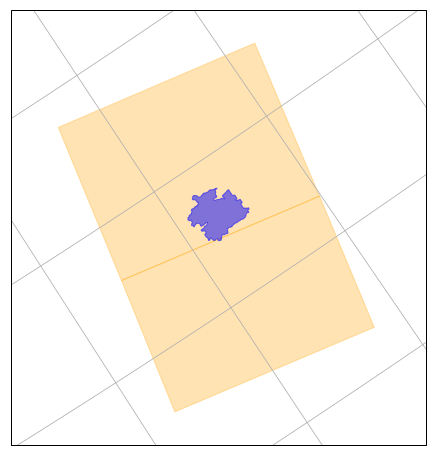

In [10]:
s1_imgs = s1_ids[2:4]
# view image extents 
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

# Get the geometry from each feature
shapes = []
for s1_img in s1_imgs:
    metadata = dl.metadata.get(s1_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')

ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
ax.set_extent((union.bounds[0], union.bounds[2], union.bounds[1], union.bounds[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()

### Inspect imagery

[u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A'] (785, 833, 3)


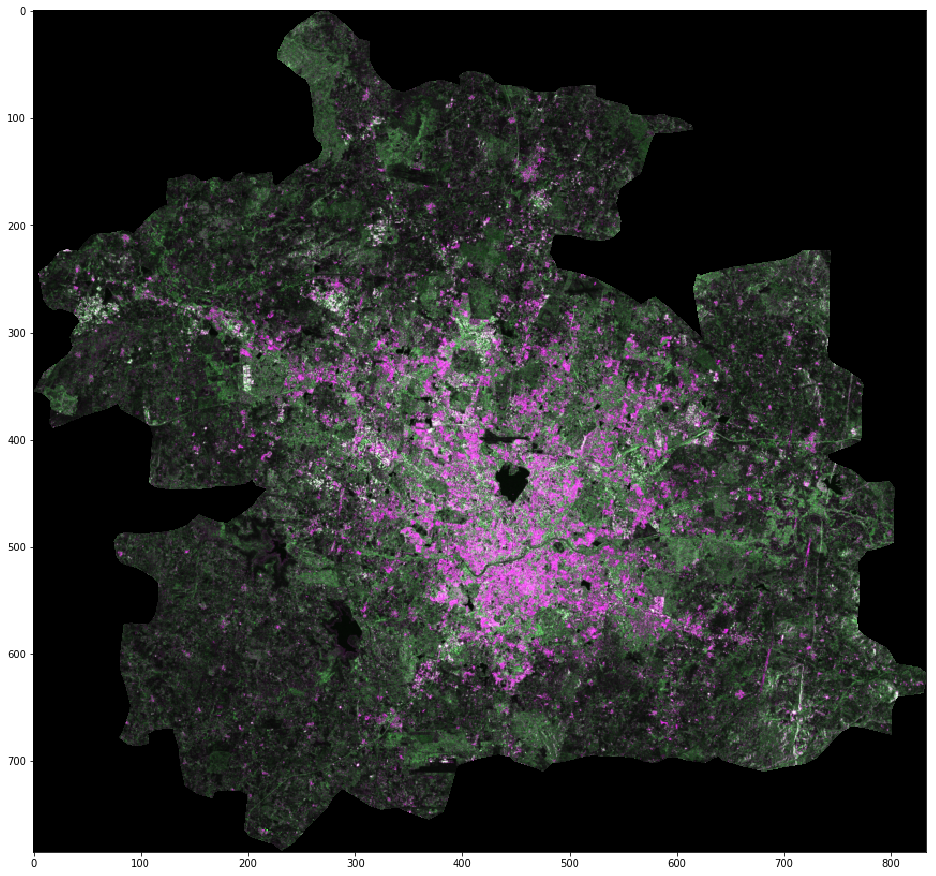

In [11]:
bronco.show_scene(s1_imgs[:], geom=shape['geometry'], resolution=80,bands=['vv','vh','vv'],scales=[[0,255],[0,255],[0,255]])

### Download imagery


In [5]:
# pull from api and save to file tiled images: sentinel-1 sar
s1_dict = {}
s1_dict['A'] = [u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']
s1_dict['B'] = [u'sentinel-1:GRD:meta_2016-02-09_165D3826_S1A', u'sentinel-1:GRD:meta_2016-02-09_165D3853_S1A']
s1_dict['C'] = [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
s1_dict['D'] = [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
s1_dict['E'] = [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
s1_dict['F'] = [u'sentinel-1:GRD:meta_2016-10-18_165D3839_S1A']
s1_dict['G'] = [u'sentinel-1:GRD:meta_2016-10-30_165D3839_S1A']
s1_dict['H'] = [u'sentinel-1:GRD:meta_2016-11-23_165D3839_S1A']
s1_dict['I'] = [u'sentinel-1:GRD:meta_2016-12-17_165D3838_S1A']
s1_dict['J'] = [u'sentinel-1:GRD:meta_2016-12-29_165D3838_S1A']
s1_dict['K'] = [u'sentinel-1:GRD:meta_2017-02-03_165D3836_S1A']
s1_dict['L'] = [u'sentinel-1:GRD:meta_2017-02-27_165D3834_S1A']
s1_dict['M'] = [u'sentinel-1:GRD:meta_2017-04-04_165D3838_S1A']
s1_dict['N'] = [u'sentinel-1:GRD:meta_2017-04-28_165D3839_S1A']
s1_dict['O'] = [u'sentinel-1:GRD:meta_2017-05-10_165D3839_S1A']
s1_dict['P'] = [u'sentinel-1:GRD:meta_2017-11-06_165D3847_S1A'] 
s1_dict['Q'] = [u'sentinel-1:GRD:meta_2017-11-30_165D3846_S1A']
s1_dict['R'] = [u'sentinel-1:GRD:meta_2017-12-12_165D3846_S1A']
s1_dict['S'] = [u'sentinel-1:GRD:meta_2017-12-24_165D3845_S1A']
s1_dict['T'] = [u'sentinel-1:GRD:meta_2017-12-24_165D3845_S1A']
s1_dict['U'] = [u'sentinel-1:GRD:meta_2018-01-05_165D3845_S1A']
s1_dict['V'] = [u'sentinel-1:GRD:meta_2018-01-17_165D3844_S1A']
s1_dict['W'] = [u'sentinel-1:GRD:meta_2018-01-29_165D3844_S1A'] 
s1_dict['X'] = [u'sentinel-1:GRD:meta_2018-01-29_165D3844_S1A'] 
s1_dict['Y'] = [u'sentinel-1:GRD:meta_2018-01-29_165D3844_S1A']
s1_dict['Z'] = [u'sentinel-1:GRD:meta_2018-02-10_165D3844_S1A']
s1_dict['AA'] = [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
s1_dict['AB'] = [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
s1_dict['AC'] = [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
s1_dict['AD'] = [u'sentinel-1:GRD:meta_2018-03-06_165D3843_S1A']
s1_dict['AE'] = [u'sentinel-1:GRD:meta_2018-03-06_165D3843_S1A']
s1_dict['AF'] = [u'sentinel-1:GRD:meta_2018-03-30_165D3844_S1A']
s1_dict['AG'] = [u'sentinel-1:GRD:meta_2018-03-30_165D3844_S1A']
s1_dict['AH'] = [u'sentinel-1:GRD:meta_2018-03-30_165D3844_S1A']
s1_dict['AI'] = [u'sentinel-1:GRD:meta_2018-04-11_165D3844_S1A']
s1_dict['AJ'] = [u'sentinel-1:GRD:meta_2018-04-11_165D3844_S1A']
s1_dict['AK'] = [u'sentinel-1:GRD:meta_2018-04-23_165D3845_S1A'] 
s1_dict['AL'] = [u'sentinel-1:GRD:meta_2018-04-23_165D3845_S1A']
s1_dict['AM'] = [u'sentinel-1:GRD:meta_2018-05-05_165D3845_S1A']
s1_dict['AN'] = [u'sentinel-1:GRD:meta_2018-05-17_165D3846_S1A']
s1_dict['AO'] = [u'sentinel-1:GRD:meta_2018-05-17_165D3846_S1A']
s1_dict['AP'] = [u'sentinel-1:GRD:meta_2018-05-29_165D3847_S1A']
s1_dict['AQ'] = [u'sentinel-1:GRD:meta_2018-09-02_165D3852_S1A']
 

for sar_suffix, s1_imgs in s1_dict.iteritems():
    print sar_suffix, s1_imgs
    continue_index = 0

    for tile_id in range(len(tiles['features'])):
        if (tile_id < continue_index):
            print 'tile', tile_id, 'continuing'
            continue
        tile = tiles['features'][tile_id]
        print 'tile', tile_id, 'download SAR image'
        sar_band_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_sar_'+sar_suffix
        print sar_band_file
        sar = dl.raster.raster(
                s1_imgs,
                bands=s1_bands,
                data_type='UInt16',
                dltile=tile,
                cutline=shape['geometry'],
                save=True,
                outfile_basename=sar_band_file)

AA [u'sentinel-1:GRD:meta_2018-02-22_165D3843_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_AA
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_AA
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_AA
tile 3 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile003_sar_AA
tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_AA
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_AA
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_AA
tile 7 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile007_sar_AA
tile 8 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile008_sar_AA
tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_AA
tile 10 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile010_sar_AA
tile 11 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile011_sar_AA
tile 12 download SAR i

tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_AA
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_AA
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_AA
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_AA
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_AA
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_AA
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_AA
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_AA
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile113_sar_AA
tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_AA
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_AA
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile116_sar_AA
tile 117 download SAR image
/data/phase_iii/hyderaba

tile 209 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile209_sar_AA
tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_AA
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_AA
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_AA
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_AA
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_AA
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_AA
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_AA
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_AA
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_AA
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_AA
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_AA
tile 221 download SAR image
/data/phase_iii/hyderaba

tile 313 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile313_sar_AA
tile 314 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile314_sar_AA
tile 315 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile315_sar_AA
tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_AA
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_AA
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_AA
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_AA
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_AA
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_AA
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_AA
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_AA
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_AA
tile 325 download SAR image
/data/phase_iii/hyderaba

tile 417 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile417_sar_AA
tile 418 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile418_sar_AA
tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_AA
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile420_sar_AA
tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_AA
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_AA
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_AA
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_AA
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_AA
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_AA
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_AA
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_AA
tile 429 download SAR image
/data/phase_iii/hyderaba

tile 63 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile063_sar_AN
tile 64 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile064_sar_AN
tile 65 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile065_sar_AN
tile 66 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile066_sar_AN
tile 67 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile067_sar_AN
tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_AN
tile 69 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile069_sar_AN
tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_AN
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_AN
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_AN
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_AN
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_AN
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 169 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile169_sar_AN
tile 170 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile170_sar_AN
tile 171 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile171_sar_AN
tile 172 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile172_sar_AN
tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_AN
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile174_sar_AN
tile 175 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile175_sar_AN
tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_AN
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_AN
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_AN
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_AN
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_AN
tile 181 download SAR image
/data/phase_iii/hyderaba

tile 273 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile273_sar_AN
tile 274 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile274_sar_AN
tile 275 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile275_sar_AN
tile 276 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile276_sar_AN
tile 277 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile277_sar_AN
tile 278 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile278_sar_AN
tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_AN
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile280_sar_AN
tile 281 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile281_sar_AN
tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_AN
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_AN
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_AN
tile 285 download SAR image
/data/phase_iii/hyderaba

tile 377 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile377_sar_AN
tile 378 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile378_sar_AN
tile 379 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile379_sar_AN
tile 380 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile380_sar_AN
tile 381 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile381_sar_AN
tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile382_sar_AN
tile 383 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile383_sar_AN
tile 384 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile384_sar_AN
tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_AN
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile386_sar_AN
tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_AN
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_AN
tile 389 download SAR image
/data/phase_iii/hyderaba

tile 23 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile023_sar_AC
tile 24 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile024_sar_AC
tile 25 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile025_sar_AC
tile 26 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile026_sar_AC
tile 27 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile027_sar_AC
tile 28 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile028_sar_AC
tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_AC
tile 30 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile030_sar_AC
tile 31 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile031_sar_AC
tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_AC
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_AC
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_AC
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 128 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile128_sar_AC
tile 129 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile129_sar_AC
tile 130 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile130_sar_AC
tile 131 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile131_sar_AC
tile 132 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile132_sar_AC
tile 133 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile133_sar_AC
tile 134 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile134_sar_AC
tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_AC
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile136_sar_AC
tile 137 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile137_sar_AC
tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_AC
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_AC
tile 140 download SAR image
/data/phase_iii/hyderaba

tile 232 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile232_sar_AC
tile 233 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile233_sar_AC
tile 234 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile234_sar_AC
tile 235 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile235_sar_AC
tile 236 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile236_sar_AC
tile 237 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile237_sar_AC
tile 238 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile238_sar_AC
tile 239 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile239_sar_AC
tile 240 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile240_sar_AC
tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_AC
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_AC
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_AC
tile 244 download SAR image
/data/phase_iii/hyderaba

tile 336 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile336_sar_AC
tile 337 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile337_sar_AC
tile 338 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile338_sar_AC
tile 339 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile339_sar_AC
tile 340 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile340_sar_AC
tile 341 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile341_sar_AC
tile 342 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile342_sar_AC
tile 343 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile343_sar_AC
tile 344 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile344_sar_AC
tile 345 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile345_sar_AC
tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_AC
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_AC
tile 348 download SAR image
/data/phase_iii/hyderaba

tile 440 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile440_sar_AC
tile 441 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile441_sar_AC
tile 442 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile442_sar_AC
tile 443 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile443_sar_AC
tile 444 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile444_sar_AC
tile 445 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile445_sar_AC
tile 446 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile446_sar_AC
tile 447 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile447_sar_AC
tile 448 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile448_sar_AC
tile 449 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile449_sar_AC
tile 450 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile450_sar_AC
tile 451 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile451_sar_AC
tile 452 download SAR image
/data/phase_iii/hyderaba

tile 87 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile087_sar_AJ
tile 88 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile088_sar_AJ
tile 89 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile089_sar_AJ
tile 90 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile090_sar_AJ
tile 91 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile091_sar_AJ
tile 92 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile092_sar_AJ
tile 93 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile093_sar_AJ
tile 94 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile094_sar_AJ
tile 95 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile095_sar_AJ
tile 96 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile096_sar_AJ
tile 97 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile097_sar_AJ
tile 98 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile098_sar_AJ
tile 99 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 191 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile191_sar_AJ
tile 192 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile192_sar_AJ
tile 193 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile193_sar_AJ
tile 194 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile194_sar_AJ
tile 195 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile195_sar_AJ
tile 196 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile196_sar_AJ
tile 197 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile197_sar_AJ
tile 198 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile198_sar_AJ
tile 199 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile199_sar_AJ
tile 200 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile200_sar_AJ
tile 201 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile201_sar_AJ
tile 202 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile202_sar_AJ
tile 203 download SAR image
/data/phase_iii/hyderaba

tile 295 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile295_sar_AJ
tile 296 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile296_sar_AJ
tile 297 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile297_sar_AJ
tile 298 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile298_sar_AJ
tile 299 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile299_sar_AJ
tile 300 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile300_sar_AJ
tile 301 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile301_sar_AJ
tile 302 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile302_sar_AJ
tile 303 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile303_sar_AJ
tile 304 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile304_sar_AJ
tile 305 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile305_sar_AJ
tile 306 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile306_sar_AJ
tile 307 download SAR image
/data/phase_iii/hyderaba

tile 399 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile399_sar_AJ
tile 400 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile400_sar_AJ
tile 401 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile401_sar_AJ
tile 402 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile402_sar_AJ
tile 403 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile403_sar_AJ
tile 404 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile404_sar_AJ
tile 405 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile405_sar_AJ
tile 406 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile406_sar_AJ
tile 407 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile407_sar_AJ
tile 408 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile408_sar_AJ
tile 409 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile409_sar_AJ
tile 410 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile410_sar_AJ
tile 411 download SAR image
/data/phase_iii/hyderaba

tile 45 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile045_sar_AB
tile 46 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile046_sar_AB
tile 47 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile047_sar_AB
tile 48 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile048_sar_AB
tile 49 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile049_sar_AB
tile 50 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile050_sar_AB
tile 51 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile051_sar_AB
tile 52 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile052_sar_AB
tile 53 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile053_sar_AB
tile 54 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile054_sar_AB
tile 55 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile055_sar_AB
tile 56 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile056_sar_AB
tile 57 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 150 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile150_sar_AB
tile 151 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile151_sar_AB
tile 152 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile152_sar_AB
tile 153 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile153_sar_AB
tile 154 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile154_sar_AB
tile 155 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile155_sar_AB
tile 156 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile156_sar_AB
tile 157 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile157_sar_AB
tile 158 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile158_sar_AB
tile 159 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile159_sar_AB
tile 160 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile160_sar_AB
tile 161 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile161_sar_AB
tile 162 download SAR image
/data/phase_iii/hyderaba

tile 254 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile254_sar_AB
tile 255 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile255_sar_AB
tile 256 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile256_sar_AB
tile 257 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile257_sar_AB
tile 258 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile258_sar_AB
tile 259 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile259_sar_AB
tile 260 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile260_sar_AB
tile 261 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile261_sar_AB
tile 262 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile262_sar_AB
tile 263 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile263_sar_AB
tile 264 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile264_sar_AB
tile 265 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile265_sar_AB
tile 266 download SAR image
/data/phase_iii/hyderaba

tile 358 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile358_sar_AB
tile 359 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile359_sar_AB
tile 360 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile360_sar_AB
tile 361 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile361_sar_AB
tile 362 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile362_sar_AB
tile 363 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile363_sar_AB
tile 364 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile364_sar_AB
tile 365 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile365_sar_AB
tile 366 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile366_sar_AB
tile 367 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile367_sar_AB
tile 368 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile368_sar_AB
tile 369 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile369_sar_AB
tile 370 download SAR image
/data/phase_iii/hyderaba

tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_AE
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_AE
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_AE
tile 7 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile007_sar_AE
tile 8 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile008_sar_AE
tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_AE
tile 10 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile010_sar_AE
tile 11 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile011_sar_AE
tile 12 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile012_sar_AE
tile 13 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile013_sar_AE
tile 14 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile014_sar_AE
tile 15 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile015_sar_AE
tile 16 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile016

tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_AE
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_AE
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_AE
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_AE
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile113_sar_AE
tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_AE
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_AE
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile116_sar_AE
tile 117 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile117_sar_AE
tile 118 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile118_sar_AE
tile 119 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile119_sar_AE
tile 120 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile120_sar_AE
tile 121 download SAR image
/data/phase_iii/hyderaba

tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_AE
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_AE
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_AE
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_AE
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_AE
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_AE
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_AE
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_AE
tile 221 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile221_sar_AE
tile 222 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile222_sar_AE
tile 223 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile223_sar_AE
tile 224 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile224_sar_AE
tile 225 download SAR image
/data/phase_iii/hyderaba

tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_AE
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_AE
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_AE
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_AE
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_AE
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_AE
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_AE
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_AE
tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile325_sar_AE
tile 326 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile326_sar_AE
tile 327 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile327_sar_AE
tile 328 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile328_sar_AE
tile 329 download SAR image
/data/phase_iii/hyderaba

tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_AE
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_AE
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_AE
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_AE
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_AE
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_AE
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_AE
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_AE
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_AE
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile430_sar_AE
tile 431 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile431_sar_AE
tile 432 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile432_sar_AE
tile 433 download SAR image
/data/phase_iii/hyderaba

tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_AD
tile 69 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile069_sar_AD
tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_AD
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_AD
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_AD
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_AD
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_AD
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_AD
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_AD
tile 77 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile077_sar_AD
tile 78 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile078_sar_AD
tile 79 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile079_sar_AD
tile 80 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_AD
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile174_sar_AD
tile 175 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile175_sar_AD
tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_AD
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_AD
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_AD
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_AD
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_AD
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_AD
tile 182 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile182_sar_AD
tile 183 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile183_sar_AD
tile 184 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile184_sar_AD
tile 185 download SAR image
/data/phase_iii/hyderaba

tile 277 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile277_sar_AD
tile 278 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile278_sar_AD
tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_AD
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile280_sar_AD
tile 281 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile281_sar_AD
tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_AD
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_AD
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_AD
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_AD
tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_AD
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile287_sar_AD
tile 288 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile288_sar_AD
tile 289 download SAR image
/data/phase_iii/hyderaba

tile 381 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile381_sar_AD
tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile382_sar_AD
tile 383 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile383_sar_AD
tile 384 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile384_sar_AD
tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_AD
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile386_sar_AD
tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_AD
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_AD
tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_AD
tile 390 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile390_sar_AD
tile 391 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile391_sar_AD
tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_AD
tile 393 download SAR image
/data/phase_iii/hyderaba

tile 27 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile027_sar_AG
tile 28 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile028_sar_AG
tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_AG
tile 30 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile030_sar_AG
tile 31 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile031_sar_AG
tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_AG
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_AG
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_AG
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile035_sar_AG
tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile036_sar_AG
tile 37 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile037_sar_AG
tile 38 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile038_sar_AG
tile 39 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 132 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile132_sar_AG
tile 133 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile133_sar_AG
tile 134 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile134_sar_AG
tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_AG
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile136_sar_AG
tile 137 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile137_sar_AG
tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_AG
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_AG
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_AG
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile141_sar_AG
tile 142 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile142_sar_AG
tile 143 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile143_sar_AG
tile 144 download SAR image
/data/phase_iii/hyderaba

tile 236 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile236_sar_AG
tile 237 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile237_sar_AG
tile 238 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile238_sar_AG
tile 239 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile239_sar_AG
tile 240 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile240_sar_AG
tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_AG
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_AG
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_AG
tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_AG
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_AG
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_AG
tile 247 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile247_sar_AG
tile 248 download SAR image
/data/phase_iii/hyderaba

tile 340 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile340_sar_AG
tile 341 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile341_sar_AG
tile 342 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile342_sar_AG
tile 343 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile343_sar_AG
tile 344 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile344_sar_AG
tile 345 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile345_sar_AG
tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_AG
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_AG
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile348_sar_AG
tile 349 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile349_sar_AG
tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_AG
tile 351 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile351_sar_AG
tile 352 download SAR image
/data/phase_iii/hyderaba

tile 444 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile444_sar_AG
tile 445 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile445_sar_AG
tile 446 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile446_sar_AG
tile 447 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile447_sar_AG
tile 448 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile448_sar_AG
tile 449 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile449_sar_AG
tile 450 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile450_sar_AG
tile 451 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile451_sar_AG
tile 452 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile452_sar_AG
tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_AG
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile454_sar_AG
tile 455 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile455_sar_AG
tile 456 download SAR image
/data/phase_iii/hyderaba

tile 91 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile091_sar_AF
tile 92 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile092_sar_AF
tile 93 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile093_sar_AF
tile 94 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile094_sar_AF
tile 95 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile095_sar_AF
tile 96 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile096_sar_AF
tile 97 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile097_sar_AF
tile 98 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile098_sar_AF
tile 99 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile099_sar_AF
tile 100 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile100_sar_AF
tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_AF
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sar_AF
tile 103 download SAR image
/data/phase_iii/hyderabad/hyderab

tile 195 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile195_sar_AF
tile 196 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile196_sar_AF
tile 197 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile197_sar_AF
tile 198 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile198_sar_AF
tile 199 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile199_sar_AF
tile 200 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile200_sar_AF
tile 201 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile201_sar_AF
tile 202 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile202_sar_AF
tile 203 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile203_sar_AF
tile 204 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile204_sar_AF
tile 205 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile205_sar_AF
tile 206 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile206_sar_AF
tile 207 download SAR image
/data/phase_iii/hyderaba

tile 299 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile299_sar_AF
tile 300 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile300_sar_AF
tile 301 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile301_sar_AF
tile 302 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile302_sar_AF
tile 303 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile303_sar_AF
tile 304 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile304_sar_AF
tile 305 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile305_sar_AF
tile 306 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile306_sar_AF
tile 307 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile307_sar_AF
tile 308 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile308_sar_AF
tile 309 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile309_sar_AF
tile 310 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile310_sar_AF
tile 311 download SAR image
/data/phase_iii/hyderaba

tile 403 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile403_sar_AF
tile 404 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile404_sar_AF
tile 405 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile405_sar_AF
tile 406 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile406_sar_AF
tile 407 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile407_sar_AF
tile 408 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile408_sar_AF
tile 409 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile409_sar_AF
tile 410 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile410_sar_AF
tile 411 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile411_sar_AF
tile 412 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile412_sar_AF
tile 413 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile413_sar_AF
tile 414 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile414_sar_AF
tile 415 download SAR image
/data/phase_iii/hyderaba

tile 49 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile049_sar_AM
tile 50 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile050_sar_AM
tile 51 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile051_sar_AM
tile 52 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile052_sar_AM
tile 53 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile053_sar_AM
tile 54 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile054_sar_AM
tile 55 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile055_sar_AM
tile 56 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile056_sar_AM
tile 57 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile057_sar_AM
tile 58 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile058_sar_AM
tile 59 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile059_sar_AM
tile 60 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile060_sar_AM
tile 61 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 154 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile154_sar_AM
tile 155 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile155_sar_AM
tile 156 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile156_sar_AM
tile 157 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile157_sar_AM
tile 158 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile158_sar_AM
tile 159 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile159_sar_AM
tile 160 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile160_sar_AM
tile 161 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile161_sar_AM
tile 162 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile162_sar_AM
tile 163 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile163_sar_AM
tile 164 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile164_sar_AM
tile 165 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile165_sar_AM
tile 166 download SAR image
/data/phase_iii/hyderaba

tile 258 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile258_sar_AM
tile 259 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile259_sar_AM
tile 260 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile260_sar_AM
tile 261 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile261_sar_AM
tile 262 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile262_sar_AM
tile 263 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile263_sar_AM
tile 264 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile264_sar_AM
tile 265 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile265_sar_AM
tile 266 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile266_sar_AM
tile 267 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile267_sar_AM
tile 268 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile268_sar_AM
tile 269 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile269_sar_AM
tile 270 download SAR image
/data/phase_iii/hyderaba

tile 363 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile363_sar_AM
tile 364 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile364_sar_AM
tile 365 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile365_sar_AM
tile 366 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile366_sar_AM
tile 367 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile367_sar_AM
tile 368 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile368_sar_AM
tile 369 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile369_sar_AM
tile 370 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile370_sar_AM
tile 371 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile371_sar_AM
tile 372 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile372_sar_AM
tile 373 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile373_sar_AM
tile 374 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile374_sar_AM
tile 375 download SAR image
/data/phase_iii/hyderaba

tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_AI
tile 10 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile010_sar_AI
tile 11 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile011_sar_AI
tile 12 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile012_sar_AI
tile 13 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile013_sar_AI
tile 14 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile014_sar_AI
tile 15 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile015_sar_AI
tile 16 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile016_sar_AI
tile 17 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile017_sar_AI
tile 18 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile018_sar_AI
tile 19 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile019_sar_AI
tile 20 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile020_sar_AI
tile 21 download SAR image
/data/phase_iii/hyderabad/hyderabad_ti

tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_AI
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_AI
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile116_sar_AI
tile 117 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile117_sar_AI
tile 118 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile118_sar_AI
tile 119 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile119_sar_AI
tile 120 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile120_sar_AI
tile 121 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile121_sar_AI
tile 122 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile122_sar_AI
tile 123 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile123_sar_AI
tile 124 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile124_sar_AI
tile 125 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile125_sar_AI
tile 126 download SAR image
/data/phase_iii/hyderaba

tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_AI
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_AI
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_AI
tile 221 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile221_sar_AI
tile 222 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile222_sar_AI
tile 223 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile223_sar_AI
tile 224 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile224_sar_AI
tile 225 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile225_sar_AI
tile 226 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile226_sar_AI
tile 227 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile227_sar_AI
tile 228 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile228_sar_AI
tile 229 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile229_sar_AI
tile 230 download SAR image
/data/phase_iii/hyderaba

tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_AI
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_AI
tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile325_sar_AI
tile 326 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile326_sar_AI
tile 327 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile327_sar_AI
tile 328 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile328_sar_AI
tile 329 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile329_sar_AI
tile 330 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile330_sar_AI
tile 331 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile331_sar_AI
tile 332 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile332_sar_AI
tile 333 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile333_sar_AI
tile 334 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile334_sar_AI
tile 335 download SAR image
/data/phase_iii/hyderaba

tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_AI
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_AI
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_AI
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile430_sar_AI
tile 431 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile431_sar_AI
tile 432 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile432_sar_AI
tile 433 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile433_sar_AI
tile 434 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile434_sar_AI
tile 435 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile435_sar_AI
tile 436 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile436_sar_AI
tile 437 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile437_sar_AI
tile 438 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile438_sar_AI
tile 439 download SAR image
/data/phase_iii/hyderaba

tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_AH
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_AH
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_AH
tile 77 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile077_sar_AH
tile 78 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile078_sar_AH
tile 79 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile079_sar_AH
tile 80 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile080_sar_AH
tile 81 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile081_sar_AH
tile 82 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile082_sar_AH
tile 83 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile083_sar_AH
tile 84 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile084_sar_AH
tile 85 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile085_sar_AH
tile 86 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_AH
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_AH
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_AH
tile 182 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile182_sar_AH
tile 183 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile183_sar_AH
tile 184 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile184_sar_AH
tile 185 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile185_sar_AH
tile 186 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile186_sar_AH
tile 187 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile187_sar_AH
tile 188 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile188_sar_AH
tile 189 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile189_sar_AH
tile 190 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile190_sar_AH
tile 191 download SAR image
/data/phase_iii/hyderaba

tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_AH
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_AH
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_AH
tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_AH
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile287_sar_AH
tile 288 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile288_sar_AH
tile 289 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile289_sar_AH
tile 290 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile290_sar_AH
tile 291 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile291_sar_AH
tile 292 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile292_sar_AH
tile 293 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile293_sar_AH
tile 294 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile294_sar_AH
tile 295 download SAR image
/data/phase_iii/hyderaba

tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_AH
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_AH
tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_AH
tile 390 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile390_sar_AH
tile 391 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile391_sar_AH
tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_AH
tile 393 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile393_sar_AH
tile 394 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile394_sar_AH
tile 395 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile395_sar_AH
tile 396 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile396_sar_AH
tile 397 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile397_sar_AH
tile 398 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile398_sar_AH
tile 399 download SAR image
/data/phase_iii/hyderaba

tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_AK
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_AK
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile035_sar_AK
tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile036_sar_AK
tile 37 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile037_sar_AK
tile 38 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile038_sar_AK
tile 39 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile039_sar_AK
tile 40 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile040_sar_AK
tile 41 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile041_sar_AK
tile 42 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile042_sar_AK
tile 43 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile043_sar_AK
tile 44 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile044_sar_AK
tile 45 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_AK
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_AK
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_AK
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile141_sar_AK
tile 142 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile142_sar_AK
tile 143 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile143_sar_AK
tile 144 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile144_sar_AK
tile 145 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile145_sar_AK
tile 146 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile146_sar_AK
tile 147 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile147_sar_AK
tile 148 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile148_sar_AK
tile 149 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile149_sar_AK
tile 150 download SAR image
/data/phase_iii/hyderaba

tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_AK
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_AK
tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_AK
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_AK
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_AK
tile 247 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile247_sar_AK
tile 248 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile248_sar_AK
tile 249 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile249_sar_AK
tile 250 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile250_sar_AK
tile 251 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile251_sar_AK
tile 252 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile252_sar_AK
tile 253 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile253_sar_AK
tile 254 download SAR image
/data/phase_iii/hyderaba

tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_AK
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_AK
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile348_sar_AK
tile 349 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile349_sar_AK
tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_AK
tile 351 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile351_sar_AK
tile 352 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile352_sar_AK
tile 353 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile353_sar_AK
tile 354 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile354_sar_AK
tile 355 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile355_sar_AK
tile 356 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile356_sar_AK
tile 357 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile357_sar_AK
tile 358 download SAR image
/data/phase_iii/hyderaba

tile 450 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile450_sar_AK
tile 451 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile451_sar_AK
tile 452 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile452_sar_AK
tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_AK
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile454_sar_AK
tile 455 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile455_sar_AK
tile 456 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile456_sar_AK
tile 457 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile457_sar_AK
A [u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_A
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_A
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_A
tile 3 download SAR image
/data/phase_iii

tile 98 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile098_sar_A
tile 99 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile099_sar_A
tile 100 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile100_sar_A
tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_A
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sar_A
tile 103 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile103_sar_A
tile 104 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile104_sar_A
tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_A
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_A
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_A
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_A
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_A
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_ti

tile 204 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile204_sar_A
tile 205 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile205_sar_A
tile 206 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile206_sar_A
tile 207 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile207_sar_A
tile 208 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile208_sar_A
tile 209 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile209_sar_A
tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_A
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_A
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_A
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_A
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_A
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_A
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 310 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile310_sar_A
tile 311 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile311_sar_A
tile 312 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile312_sar_A
tile 313 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile313_sar_A
tile 314 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile314_sar_A
tile 315 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile315_sar_A
tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_A
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_A
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_A
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_A
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_A
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_A
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 416 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile416_sar_A
tile 417 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile417_sar_A
tile 418 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile418_sar_A
tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_A
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile420_sar_A
tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_A
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_A
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_A
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_A
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_A
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_A
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_A
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 64 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile064_sar_C
tile 65 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile065_sar_C
tile 66 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile066_sar_C
tile 67 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile067_sar_C
tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_C
tile 69 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile069_sar_C
tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_C
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_C
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_C
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_C
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_C
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_C
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_C

tile 170 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile170_sar_C
tile 171 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile171_sar_C
tile 172 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile172_sar_C
tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_C
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile174_sar_C
tile 175 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile175_sar_C
tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_C
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_C
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_C
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_C
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_C
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_C
tile 182 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 276 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile276_sar_C
tile 277 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile277_sar_C
tile 278 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile278_sar_C
tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_C
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile280_sar_C
tile 281 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile281_sar_C
tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_C
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_C
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_C
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_C
tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_C
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile287_sar_C
tile 288 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile382_sar_C
tile 383 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile383_sar_C
tile 384 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile384_sar_C
tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_C
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile386_sar_C
tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_C
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_C
tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_C
tile 390 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile390_sar_C
tile 391 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile391_sar_C
tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_C
tile 393 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile393_sar_C
tile 394 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_B
tile 30 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile030_sar_B
tile 31 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile031_sar_B
tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_B
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_B
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_B
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile035_sar_B
tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile036_sar_B
tile 37 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile037_sar_B
tile 38 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile038_sar_B
tile 39 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile039_sar_B
tile 40 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile040_sar_B
tile 41 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile041_sar_B

tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_B
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile136_sar_B
tile 137 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile137_sar_B
tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_B
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_B
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_B
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile141_sar_B
tile 142 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile142_sar_B
tile 143 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile143_sar_B
tile 144 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile144_sar_B
tile 145 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile145_sar_B
tile 146 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile146_sar_B
tile 147 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_B
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_B
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_B
tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_B
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_B
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_B
tile 247 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile247_sar_B
tile 248 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile248_sar_B
tile 249 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile249_sar_B
tile 250 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile250_sar_B
tile 251 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile251_sar_B
tile 252 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile252_sar_B
tile 253 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_B
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile348_sar_B
tile 349 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile349_sar_B
tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_B
tile 351 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile351_sar_B
tile 352 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile352_sar_B
tile 353 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile353_sar_B
tile 354 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile354_sar_B
tile 355 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile355_sar_B
tile 356 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile356_sar_B
tile 357 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile357_sar_B
tile 358 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile358_sar_B
tile 359 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_B
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile454_sar_B
tile 455 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile455_sar_B
tile 456 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile456_sar_B
tile 457 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile457_sar_B
E [u'sentinel-1:GRD:meta_2016-03-04_165D3841_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_E
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_E
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_E
tile 3 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile003_sar_E
tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_E
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_E
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_E
tile 7 download SAR image
/

tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_E
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sar_E
tile 103 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile103_sar_E
tile 104 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile104_sar_E
tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_E
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_E
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_E
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_E
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_E
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_E
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_E
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_E
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 207 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile207_sar_E
tile 208 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile208_sar_E
tile 209 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile209_sar_E
tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_E
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_E
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_E
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_E
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_E
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_E
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_E
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_E
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_E
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 313 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile313_sar_E
tile 314 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile314_sar_E
tile 315 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile315_sar_E
tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_E
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_E
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_E
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_E
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_E
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_E
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_E
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_E
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_E
tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_E
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile420_sar_E
tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_E
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_E
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_E
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_E
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_E
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_E
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_E
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_E
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_E
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile430_sar_E
tile 431 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 67 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile067_sar_D
tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_D
tile 69 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile069_sar_D
tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_D
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_D
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_D
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_D
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_D
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_D
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_D
tile 77 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile077_sar_D
tile 78 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile078_sar_D
tile 79 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile079_sar_D

tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_D
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile174_sar_D
tile 175 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile175_sar_D
tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_D
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_D
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_D
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_D
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_D
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_D
tile 182 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile182_sar_D
tile 183 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile183_sar_D
tile 184 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile184_sar_D
tile 185 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_D
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile280_sar_D
tile 281 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile281_sar_D
tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_D
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_D
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_D
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_D
tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_D
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile287_sar_D
tile 288 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile288_sar_D
tile 289 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile289_sar_D
tile 290 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile290_sar_D
tile 291 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_D
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile386_sar_D
tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_D
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_D
tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_D
tile 390 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile390_sar_D
tile 391 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile391_sar_D
tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_D
tile 393 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile393_sar_D
tile 394 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile394_sar_D
tile 395 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile395_sar_D
tile 396 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile396_sar_D
tile 397 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_G
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_G
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_G
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile035_sar_G
tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile036_sar_G
tile 37 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile037_sar_G
tile 38 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile038_sar_G
tile 39 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile039_sar_G
tile 40 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile040_sar_G
tile 41 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile041_sar_G
tile 42 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile042_sar_G
tile 43 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile043_sar_G
tile 44 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile044_sar_G

tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_G
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_G
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_G
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile141_sar_G
tile 142 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile142_sar_G
tile 143 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile143_sar_G
tile 144 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile144_sar_G
tile 145 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile145_sar_G
tile 146 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile146_sar_G
tile 147 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile147_sar_G
tile 148 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile148_sar_G
tile 149 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile149_sar_G
tile 150 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_G
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_G
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_G
tile 247 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile247_sar_G
tile 248 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile248_sar_G
tile 249 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile249_sar_G
tile 250 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile250_sar_G
tile 251 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile251_sar_G
tile 252 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile252_sar_G
tile 253 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile253_sar_G
tile 254 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile254_sar_G
tile 255 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile255_sar_G
tile 256 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_G
tile 351 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile351_sar_G
tile 352 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile352_sar_G
tile 353 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile353_sar_G
tile 354 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile354_sar_G
tile 355 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile355_sar_G
tile 356 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile356_sar_G
tile 357 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile357_sar_G
tile 358 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile358_sar_G
tile 359 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile359_sar_G
tile 360 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile360_sar_G
tile 361 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile361_sar_G
tile 362 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 456 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile456_sar_G
tile 457 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile457_sar_G
F [u'sentinel-1:GRD:meta_2016-10-18_165D3839_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_F
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_F
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_F
tile 3 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile003_sar_F
tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_F
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_F
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_F
tile 7 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile007_sar_F
tile 8 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile008_sar_F
tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_F
tile 10 download SAR image
/data/

tile 104 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile104_sar_F
tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_F
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_F
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_F
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_F
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_F
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_F
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_F
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_F
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile113_sar_F
tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_F
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_F
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_F
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_F
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_F
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_F
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_F
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_F
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_F
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_F
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_F
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_F
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_F
tile 221 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile221_sar_F
tile 222 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_F
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_F
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_F
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_F
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_F
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_F
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_F
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_F
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_F
tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile325_sar_F
tile 326 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile326_sar_F
tile 327 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile327_sar_F
tile 328 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_F
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_F
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_F
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_F
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_F
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_F
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_F
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_F
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile430_sar_F
tile 431 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile431_sar_F
tile 432 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile432_sar_F
tile 433 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile433_sar_F
tile 434 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_I
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_I
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_I
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_I
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_I
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_I
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_I
tile 77 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile077_sar_I
tile 78 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile078_sar_I
tile 79 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile079_sar_I
tile 80 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile080_sar_I
tile 81 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile081_sar_I
tile 82 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile082_sar_I

tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_I
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_I
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_I
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_I
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_I
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_I
tile 182 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile182_sar_I
tile 183 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile183_sar_I
tile 184 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile184_sar_I
tile 185 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile185_sar_I
tile 186 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile186_sar_I
tile 187 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile187_sar_I
tile 188 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_I
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_I
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_I
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_I
tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_I
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile287_sar_I
tile 288 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile288_sar_I
tile 289 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile289_sar_I
tile 290 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile290_sar_I
tile 291 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile291_sar_I
tile 292 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile292_sar_I
tile 293 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile293_sar_I
tile 294 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_I
tile 390 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile390_sar_I
tile 391 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile391_sar_I
tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_I
tile 393 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile393_sar_I
tile 394 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile394_sar_I
tile 395 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile395_sar_I
tile 396 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile396_sar_I
tile 397 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile397_sar_I
tile 398 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile398_sar_I
tile 399 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile399_sar_I
tile 400 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile400_sar_I
tile 401 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile036_sar_H
tile 37 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile037_sar_H
tile 38 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile038_sar_H
tile 39 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile039_sar_H
tile 40 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile040_sar_H
tile 41 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile041_sar_H
tile 42 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile042_sar_H
tile 43 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile043_sar_H
tile 44 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile044_sar_H
tile 45 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile045_sar_H
tile 46 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile046_sar_H
tile 47 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile047_sar_H
tile 48 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile048_sar_H

tile 142 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile142_sar_H
tile 143 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile143_sar_H
tile 144 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile144_sar_H
tile 145 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile145_sar_H
tile 146 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile146_sar_H
tile 147 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile147_sar_H
tile 148 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile148_sar_H
tile 149 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile149_sar_H
tile 150 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile150_sar_H
tile 151 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile151_sar_H
tile 152 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile152_sar_H
tile 153 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile153_sar_H
tile 154 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 248 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile248_sar_H
tile 249 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile249_sar_H
tile 250 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile250_sar_H
tile 251 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile251_sar_H
tile 252 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile252_sar_H
tile 253 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile253_sar_H
tile 254 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile254_sar_H
tile 255 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile255_sar_H
tile 256 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile256_sar_H
tile 257 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile257_sar_H
tile 258 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile258_sar_H
tile 259 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile259_sar_H
tile 260 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 354 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile354_sar_H
tile 355 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile355_sar_H
tile 356 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile356_sar_H
tile 357 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile357_sar_H
tile 358 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile358_sar_H
tile 359 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile359_sar_H
tile 360 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile360_sar_H
tile 361 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile361_sar_H
tile 362 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile362_sar_H
tile 363 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile363_sar_H
tile 364 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile364_sar_H
tile 365 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile365_sar_H
tile 366 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_K
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_K
tile 3 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile003_sar_K
tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_K
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_K
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_K
tile 7 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile007_sar_K
tile 8 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile008_sar_K
tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_K
tile 10 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile010_sar_K
tile 11 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile011_sar_K
tile 12 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile012_sar_K
tile 13 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile013_sar_K
tile 14 

tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_K
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_K
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_K
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_K
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_K
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile113_sar_K
tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_K
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_K
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile116_sar_K
tile 117 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile117_sar_K
tile 118 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile118_sar_K
tile 119 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile119_sar_K
tile 120 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_K
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_K
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_K
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_K
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile218_sar_K
tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_K
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_K
tile 221 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile221_sar_K
tile 222 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile222_sar_K
tile 223 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile223_sar_K
tile 224 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile224_sar_K
tile 225 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile225_sar_K
tile 226 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_K
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_K
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_K
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_K
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile324_sar_K
tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile325_sar_K
tile 326 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile326_sar_K
tile 327 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile327_sar_K
tile 328 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile328_sar_K
tile 329 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile329_sar_K
tile 330 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile330_sar_K
tile 331 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile331_sar_K
tile 332 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_K
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_K
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_K
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_K
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile430_sar_K
tile 431 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile431_sar_K
tile 432 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile432_sar_K
tile 433 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile433_sar_K
tile 434 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile434_sar_K
tile 435 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile435_sar_K
tile 436 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile436_sar_K
tile 437 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile437_sar_K
tile 438 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_J
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_J
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_J
tile 77 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile077_sar_J
tile 78 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile078_sar_J
tile 79 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile079_sar_J
tile 80 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile080_sar_J
tile 81 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile081_sar_J
tile 82 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile082_sar_J
tile 83 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile083_sar_J
tile 84 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile084_sar_J
tile 85 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile085_sar_J
tile 86 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile086_sar_J

tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_J
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_J
tile 182 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile182_sar_J
tile 183 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile183_sar_J
tile 184 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile184_sar_J
tile 185 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile185_sar_J
tile 186 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile186_sar_J
tile 187 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile187_sar_J
tile 188 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile188_sar_J
tile 189 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile189_sar_J
tile 190 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile190_sar_J
tile 191 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile191_sar_J
tile 192 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_J
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile287_sar_J
tile 288 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile288_sar_J
tile 289 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile289_sar_J
tile 290 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile290_sar_J
tile 291 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile291_sar_J
tile 292 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile292_sar_J
tile 293 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile293_sar_J
tile 294 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile294_sar_J
tile 295 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile295_sar_J
tile 296 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile296_sar_J
tile 297 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile297_sar_J
tile 298 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_J
tile 393 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile393_sar_J
tile 394 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile394_sar_J
tile 395 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile395_sar_J
tile 396 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile396_sar_J
tile 397 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile397_sar_J
tile 398 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile398_sar_J
tile 399 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile399_sar_J
tile 400 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile400_sar_J
tile 401 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile401_sar_J
tile 402 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile402_sar_J
tile 403 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile403_sar_J
tile 404 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 40 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile040_sar_M
tile 41 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile041_sar_M
tile 42 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile042_sar_M
tile 43 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile043_sar_M
tile 44 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile044_sar_M
tile 45 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile045_sar_M
tile 46 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile046_sar_M
tile 47 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile047_sar_M
tile 48 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile048_sar_M
tile 49 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile049_sar_M
tile 50 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile050_sar_M
tile 51 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile051_sar_M
tile 52 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile052_sar_M

tile 146 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile146_sar_M
tile 147 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile147_sar_M
tile 148 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile148_sar_M
tile 149 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile149_sar_M
tile 150 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile150_sar_M
tile 151 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile151_sar_M
tile 152 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile152_sar_M
tile 153 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile153_sar_M
tile 154 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile154_sar_M
tile 155 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile155_sar_M
tile 156 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile156_sar_M
tile 157 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile157_sar_M
tile 158 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 252 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile252_sar_M
tile 253 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile253_sar_M
tile 254 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile254_sar_M
tile 255 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile255_sar_M
tile 256 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile256_sar_M
tile 257 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile257_sar_M
tile 258 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile258_sar_M
tile 259 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile259_sar_M
tile 260 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile260_sar_M
tile 261 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile261_sar_M
tile 262 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile262_sar_M
tile 263 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile263_sar_M
tile 264 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 358 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile358_sar_M
tile 359 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile359_sar_M
tile 360 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile360_sar_M
tile 361 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile361_sar_M
tile 362 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile362_sar_M
tile 363 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile363_sar_M
tile 364 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile364_sar_M
tile 365 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile365_sar_M
tile 366 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile366_sar_M
tile 367 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile367_sar_M
tile 368 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile368_sar_M
tile 369 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile369_sar_M
tile 370 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_L
tile 6 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile006_sar_L
tile 7 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile007_sar_L
tile 8 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile008_sar_L
tile 9 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile009_sar_L
tile 10 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile010_sar_L
tile 11 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile011_sar_L
tile 12 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile012_sar_L
tile 13 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile013_sar_L
tile 14 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile014_sar_L
tile 15 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile015_sar_L
tile 16 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile016_sar_L
tile 17 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile017_sar_L
tile

tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile112_sar_L
tile 113 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile113_sar_L
tile 114 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile114_sar_L
tile 115 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile115_sar_L
tile 116 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile116_sar_L
tile 117 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile117_sar_L
tile 118 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile118_sar_L
tile 119 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile119_sar_L
tile 120 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile120_sar_L
tile 121 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile121_sar_L
tile 122 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile122_sar_L
tile 123 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile123_sar_L
tile 124 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 219 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile219_sar_L
tile 220 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile220_sar_L
tile 221 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile221_sar_L
tile 222 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile222_sar_L
tile 223 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile223_sar_L
tile 224 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile224_sar_L
tile 225 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile225_sar_L
tile 226 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile226_sar_L
tile 227 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile227_sar_L
tile 228 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile228_sar_L
tile 229 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile229_sar_L
tile 230 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile230_sar_L
tile 231 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 325 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile325_sar_L
tile 326 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile326_sar_L
tile 327 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile327_sar_L
tile 328 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile328_sar_L
tile 329 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile329_sar_L
tile 330 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile330_sar_L
tile 331 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile331_sar_L
tile 332 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile332_sar_L
tile 333 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile333_sar_L
tile 334 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile334_sar_L
tile 335 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile335_sar_L
tile 336 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile336_sar_L
tile 337 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 431 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile431_sar_L
tile 432 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile432_sar_L
tile 433 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile433_sar_L
tile 434 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile434_sar_L
tile 435 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile435_sar_L
tile 436 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile436_sar_L
tile 437 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile437_sar_L
tile 438 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile438_sar_L
tile 439 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile439_sar_L
tile 440 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile440_sar_L
tile 441 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile441_sar_L
tile 442 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile442_sar_L
tile 443 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 80 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile080_sar_O
tile 81 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile081_sar_O
tile 82 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile082_sar_O
tile 83 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile083_sar_O
tile 84 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile084_sar_O
tile 85 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile085_sar_O
tile 86 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile086_sar_O
tile 87 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile087_sar_O
tile 88 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile088_sar_O
tile 89 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile089_sar_O
tile 90 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile090_sar_O
tile 91 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile091_sar_O
tile 92 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile092_sar_O

tile 187 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile187_sar_O
tile 188 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile188_sar_O
tile 189 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile189_sar_O
tile 190 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile190_sar_O
tile 191 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile191_sar_O
tile 192 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile192_sar_O
tile 193 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile193_sar_O
tile 194 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile194_sar_O
tile 195 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile195_sar_O
tile 196 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile196_sar_O
tile 197 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile197_sar_O
tile 198 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile198_sar_O
tile 199 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 293 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile293_sar_O
tile 294 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile294_sar_O
tile 295 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile295_sar_O
tile 296 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile296_sar_O
tile 297 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile297_sar_O
tile 298 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile298_sar_O
tile 299 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile299_sar_O
tile 300 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile300_sar_O
tile 301 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile301_sar_O
tile 302 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile302_sar_O
tile 303 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile303_sar_O
tile 304 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile304_sar_O
tile 305 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 399 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile399_sar_O
tile 400 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile400_sar_O
tile 401 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile401_sar_O
tile 402 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile402_sar_O
tile 403 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile403_sar_O
tile 404 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile404_sar_O
tile 405 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile405_sar_O
tile 406 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile406_sar_O
tile 407 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile407_sar_O
tile 408 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile408_sar_O
tile 409 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile409_sar_O
tile 410 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile410_sar_O
tile 411 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 46 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile046_sar_N
tile 47 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile047_sar_N
tile 48 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile048_sar_N
tile 49 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile049_sar_N
tile 50 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile050_sar_N
tile 51 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile051_sar_N
tile 52 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile052_sar_N
tile 53 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile053_sar_N
tile 54 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile054_sar_N
tile 55 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile055_sar_N
tile 56 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile056_sar_N
tile 57 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile057_sar_N
tile 58 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile058_sar_N

tile 152 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile152_sar_N
tile 153 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile153_sar_N
tile 154 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile154_sar_N
tile 155 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile155_sar_N
tile 156 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile156_sar_N
tile 157 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile157_sar_N
tile 158 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile158_sar_N
tile 159 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile159_sar_N
tile 160 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile160_sar_N
tile 161 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile161_sar_N
tile 162 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile162_sar_N
tile 163 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile163_sar_N
tile 164 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 258 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile258_sar_N
tile 259 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile259_sar_N
tile 260 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile260_sar_N
tile 261 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile261_sar_N
tile 262 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile262_sar_N
tile 263 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile263_sar_N
tile 264 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile264_sar_N
tile 265 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile265_sar_N
tile 266 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile266_sar_N
tile 267 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile267_sar_N
tile 268 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile268_sar_N
tile 269 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile269_sar_N
tile 270 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 365 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile365_sar_N
tile 366 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile366_sar_N
tile 367 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile367_sar_N
tile 368 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile368_sar_N
tile 369 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile369_sar_N
tile 370 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile370_sar_N
tile 371 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile371_sar_N
tile 372 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile372_sar_N
tile 373 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile373_sar_N
tile 374 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile374_sar_N
tile 375 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile375_sar_N
tile 376 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile376_sar_N
tile 377 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 12 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile012_sar_Q
tile 13 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile013_sar_Q
tile 14 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile014_sar_Q
tile 15 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile015_sar_Q
tile 16 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile016_sar_Q
tile 17 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile017_sar_Q
tile 18 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile018_sar_Q
tile 19 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile019_sar_Q
tile 20 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile020_sar_Q
tile 21 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile021_sar_Q
tile 22 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile022_sar_Q
tile 23 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile023_sar_Q
tile 24 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile024_sar_Q

tile 119 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile119_sar_Q
tile 120 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile120_sar_Q
tile 121 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile121_sar_Q
tile 122 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile122_sar_Q
tile 123 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile123_sar_Q
tile 124 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile124_sar_Q
tile 125 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile125_sar_Q
tile 126 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile126_sar_Q
tile 127 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile127_sar_Q
tile 128 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile128_sar_Q
tile 129 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile129_sar_Q
tile 130 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile130_sar_Q
tile 131 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 225 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile225_sar_Q
tile 226 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile226_sar_Q
tile 227 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile227_sar_Q
tile 228 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile228_sar_Q
tile 229 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile229_sar_Q
tile 230 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile230_sar_Q
tile 231 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile231_sar_Q
tile 232 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile232_sar_Q
tile 233 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile233_sar_Q
tile 234 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile234_sar_Q
tile 235 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile235_sar_Q
tile 236 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile236_sar_Q
tile 237 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 331 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile331_sar_Q
tile 332 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile332_sar_Q
tile 333 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile333_sar_Q
tile 334 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile334_sar_Q
tile 335 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile335_sar_Q
tile 336 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile336_sar_Q
tile 337 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile337_sar_Q
tile 338 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile338_sar_Q
tile 339 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile339_sar_Q
tile 340 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile340_sar_Q
tile 341 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile341_sar_Q
tile 342 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile342_sar_Q
tile 343 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 437 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile437_sar_Q
tile 438 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile438_sar_Q
tile 439 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile439_sar_Q
tile 440 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile440_sar_Q
tile 441 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile441_sar_Q
tile 442 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile442_sar_Q
tile 443 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile443_sar_Q
tile 444 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile444_sar_Q
tile 445 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile445_sar_Q
tile 446 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile446_sar_Q
tile 447 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile447_sar_Q
tile 448 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile448_sar_Q
tile 449 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 85 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile085_sar_P
tile 86 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile086_sar_P
tile 87 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile087_sar_P
tile 88 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile088_sar_P
tile 89 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile089_sar_P
tile 90 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile090_sar_P
tile 91 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile091_sar_P
tile 92 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile092_sar_P
tile 93 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile093_sar_P
tile 94 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile094_sar_P
tile 95 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile095_sar_P
tile 96 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile096_sar_P
tile 97 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile097_sar_P

tile 191 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile191_sar_P
tile 192 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile192_sar_P
tile 193 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile193_sar_P
tile 194 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile194_sar_P
tile 195 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile195_sar_P
tile 196 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile196_sar_P
tile 197 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile197_sar_P
tile 198 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile198_sar_P
tile 199 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile199_sar_P
tile 200 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile200_sar_P
tile 201 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile201_sar_P
tile 202 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile202_sar_P
tile 203 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 297 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile297_sar_P
tile 298 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile298_sar_P
tile 299 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile299_sar_P
tile 300 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile300_sar_P
tile 301 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile301_sar_P
tile 302 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile302_sar_P
tile 303 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile303_sar_P
tile 304 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile304_sar_P
tile 305 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile305_sar_P
tile 306 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile306_sar_P
tile 307 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile307_sar_P
tile 308 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile308_sar_P
tile 309 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 403 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile403_sar_P
tile 404 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile404_sar_P
tile 405 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile405_sar_P
tile 406 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile406_sar_P
tile 407 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile407_sar_P
tile 408 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile408_sar_P
tile 409 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile409_sar_P
tile 410 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile410_sar_P
tile 411 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile411_sar_P
tile 412 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile412_sar_P
tile 413 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile413_sar_P
tile 414 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile414_sar_P
tile 415 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 51 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile051_sar_S
tile 52 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile052_sar_S
tile 53 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile053_sar_S
tile 54 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile054_sar_S
tile 55 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile055_sar_S
tile 56 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile056_sar_S
tile 57 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile057_sar_S
tile 58 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile058_sar_S
tile 59 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile059_sar_S
tile 60 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile060_sar_S
tile 61 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile061_sar_S
tile 62 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile062_sar_S
tile 63 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile063_sar_S

tile 157 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile157_sar_S
tile 158 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile158_sar_S
tile 159 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile159_sar_S
tile 160 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile160_sar_S
tile 161 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile161_sar_S
tile 162 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile162_sar_S
tile 163 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile163_sar_S
tile 164 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile164_sar_S
tile 165 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile165_sar_S
tile 166 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile166_sar_S
tile 167 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile167_sar_S
tile 168 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile168_sar_S
tile 169 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 263 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile263_sar_S
tile 264 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile264_sar_S
tile 265 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile265_sar_S
tile 266 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile266_sar_S
tile 267 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile267_sar_S
tile 268 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile268_sar_S
tile 269 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile269_sar_S
tile 270 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile270_sar_S
tile 271 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile271_sar_S
tile 272 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile272_sar_S
tile 273 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile273_sar_S
tile 274 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile274_sar_S
tile 275 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 370 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile370_sar_S
tile 371 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile371_sar_S
tile 372 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile372_sar_S
tile 373 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile373_sar_S
tile 374 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile374_sar_S
tile 375 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile375_sar_S
tile 376 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile376_sar_S
tile 377 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile377_sar_S
tile 378 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile378_sar_S
tile 379 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile379_sar_S
tile 380 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile380_sar_S
tile 381 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile381_sar_S
tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 17 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile017_sar_R
tile 18 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile018_sar_R
tile 19 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile019_sar_R
tile 20 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile020_sar_R
tile 21 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile021_sar_R
tile 22 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile022_sar_R
tile 23 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile023_sar_R
tile 24 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile024_sar_R
tile 25 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile025_sar_R
tile 26 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile026_sar_R
tile 27 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile027_sar_R
tile 28 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile028_sar_R
tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_R

tile 124 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile124_sar_R
tile 125 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile125_sar_R
tile 126 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile126_sar_R
tile 127 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile127_sar_R
tile 128 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile128_sar_R
tile 129 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile129_sar_R
tile 130 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile130_sar_R
tile 131 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile131_sar_R
tile 132 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile132_sar_R
tile 133 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile133_sar_R
tile 134 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile134_sar_R
tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_R
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 230 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile230_sar_R
tile 231 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile231_sar_R
tile 232 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile232_sar_R
tile 233 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile233_sar_R
tile 234 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile234_sar_R
tile 235 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile235_sar_R
tile 236 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile236_sar_R
tile 237 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile237_sar_R
tile 238 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile238_sar_R
tile 239 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile239_sar_R
tile 240 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile240_sar_R
tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_R
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 336 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile336_sar_R
tile 337 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile337_sar_R
tile 338 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile338_sar_R
tile 339 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile339_sar_R
tile 340 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile340_sar_R
tile 341 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile341_sar_R
tile 342 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile342_sar_R
tile 343 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile343_sar_R
tile 344 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile344_sar_R
tile 345 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile345_sar_R
tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_R
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_R
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 442 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile442_sar_R
tile 443 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile443_sar_R
tile 444 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile444_sar_R
tile 445 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile445_sar_R
tile 446 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile446_sar_R
tile 447 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile447_sar_R
tile 448 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile448_sar_R
tile 449 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile449_sar_R
tile 450 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile450_sar_R
tile 451 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile451_sar_R
tile 452 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile452_sar_R
tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_R
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 90 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile090_sar_U
tile 91 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile091_sar_U
tile 92 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile092_sar_U
tile 93 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile093_sar_U
tile 94 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile094_sar_U
tile 95 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile095_sar_U
tile 96 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile096_sar_U
tile 97 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile097_sar_U
tile 98 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile098_sar_U
tile 99 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile099_sar_U
tile 100 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile100_sar_U
tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_U
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sa

tile 196 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile196_sar_U
tile 197 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile197_sar_U
tile 198 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile198_sar_U
tile 199 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile199_sar_U
tile 200 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile200_sar_U
tile 201 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile201_sar_U
tile 202 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile202_sar_U
tile 203 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile203_sar_U
tile 204 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile204_sar_U
tile 205 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile205_sar_U
tile 206 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile206_sar_U
tile 207 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile207_sar_U
tile 208 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 302 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile302_sar_U
tile 303 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile303_sar_U
tile 304 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile304_sar_U
tile 305 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile305_sar_U
tile 306 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile306_sar_U
tile 307 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile307_sar_U
tile 308 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile308_sar_U
tile 309 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile309_sar_U
tile 310 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile310_sar_U
tile 311 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile311_sar_U
tile 312 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile312_sar_U
tile 313 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile313_sar_U
tile 314 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 408 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile408_sar_U
tile 409 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile409_sar_U
tile 410 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile410_sar_U
tile 411 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile411_sar_U
tile 412 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile412_sar_U
tile 413 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile413_sar_U
tile 414 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile414_sar_U
tile 415 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile415_sar_U
tile 416 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile416_sar_U
tile 417 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile417_sar_U
tile 418 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile418_sar_U
tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_U
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 56 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile056_sar_T
tile 57 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile057_sar_T
tile 58 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile058_sar_T
tile 59 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile059_sar_T
tile 60 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile060_sar_T
tile 61 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile061_sar_T
tile 62 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile062_sar_T
tile 63 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile063_sar_T
tile 64 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile064_sar_T
tile 65 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile065_sar_T
tile 66 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile066_sar_T
tile 67 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile067_sar_T
tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_T

tile 162 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile162_sar_T
tile 163 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile163_sar_T
tile 164 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile164_sar_T
tile 165 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile165_sar_T
tile 166 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile166_sar_T
tile 167 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile167_sar_T
tile 168 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile168_sar_T
tile 169 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile169_sar_T
tile 170 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile170_sar_T
tile 171 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile171_sar_T
tile 172 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile172_sar_T
tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_T
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 268 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile268_sar_T
tile 269 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile269_sar_T
tile 270 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile270_sar_T
tile 271 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile271_sar_T
tile 272 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile272_sar_T
tile 273 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile273_sar_T
tile 274 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile274_sar_T
tile 275 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile275_sar_T
tile 276 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile276_sar_T
tile 277 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile277_sar_T
tile 278 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile278_sar_T
tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_T
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 374 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile374_sar_T
tile 375 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile375_sar_T
tile 376 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile376_sar_T
tile 377 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile377_sar_T
tile 378 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile378_sar_T
tile 379 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile379_sar_T
tile 380 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile380_sar_T
tile 381 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile381_sar_T
tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile382_sar_T
tile 383 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile383_sar_T
tile 384 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile384_sar_T
tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_T
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 22 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile022_sar_W
tile 23 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile023_sar_W
tile 24 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile024_sar_W
tile 25 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile025_sar_W
tile 26 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile026_sar_W
tile 27 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile027_sar_W
tile 28 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile028_sar_W
tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_W
tile 30 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile030_sar_W
tile 31 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile031_sar_W
tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_W
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_W
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_W

tile 129 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile129_sar_W
tile 130 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile130_sar_W
tile 131 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile131_sar_W
tile 132 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile132_sar_W
tile 133 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile133_sar_W
tile 134 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile134_sar_W
tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_W
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile136_sar_W
tile 137 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile137_sar_W
tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_W
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_W
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_W
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 236 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile236_sar_W
tile 237 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile237_sar_W
tile 238 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile238_sar_W
tile 239 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile239_sar_W
tile 240 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile240_sar_W
tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_W
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_W
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_W
tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_W
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_W
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_W
tile 247 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile247_sar_W
tile 248 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 342 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile342_sar_W
tile 343 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile343_sar_W
tile 344 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile344_sar_W
tile 345 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile345_sar_W
tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_W
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_W
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile348_sar_W
tile 349 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile349_sar_W
tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_W
tile 351 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile351_sar_W
tile 352 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile352_sar_W
tile 353 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile353_sar_W
tile 354 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 448 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile448_sar_W
tile 449 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile449_sar_W
tile 450 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile450_sar_W
tile 451 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile451_sar_W
tile 452 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile452_sar_W
tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_W
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile454_sar_W
tile 455 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile455_sar_W
tile 456 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile456_sar_W
tile 457 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile457_sar_W
V [u'sentinel-1:GRD:meta_2018-01-17_165D3844_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_V
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_V
tile 2 download S

tile 96 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile096_sar_V
tile 97 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile097_sar_V
tile 98 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile098_sar_V
tile 99 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile099_sar_V
tile 100 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile100_sar_V
tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_V
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sar_V
tile 103 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile103_sar_V
tile 104 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile104_sar_V
tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_V
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_V
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_V
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile

tile 202 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile202_sar_V
tile 203 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile203_sar_V
tile 204 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile204_sar_V
tile 205 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile205_sar_V
tile 206 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile206_sar_V
tile 207 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile207_sar_V
tile 208 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile208_sar_V
tile 209 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile209_sar_V
tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_V
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_V
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_V
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_V
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 309 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile309_sar_V
tile 310 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile310_sar_V
tile 311 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile311_sar_V
tile 312 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile312_sar_V
tile 313 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile313_sar_V
tile 314 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile314_sar_V
tile 315 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile315_sar_V
tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_V
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_V
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_V
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_V
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_V
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 415 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile415_sar_V
tile 416 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile416_sar_V
tile 417 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile417_sar_V
tile 418 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile418_sar_V
tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_V
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile420_sar_V
tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_V
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_V
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_V
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_V
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_V
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_V
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 63 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile063_sar_Y
tile 64 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile064_sar_Y
tile 65 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile065_sar_Y
tile 66 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile066_sar_Y
tile 67 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile067_sar_Y
tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_Y
tile 69 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile069_sar_Y
tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_Y
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_Y
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_Y
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_Y
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_Y
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_Y

tile 169 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile169_sar_Y
tile 170 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile170_sar_Y
tile 171 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile171_sar_Y
tile 172 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile172_sar_Y
tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_Y
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile174_sar_Y
tile 175 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile175_sar_Y
tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_Y
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_Y
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_Y
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_Y
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_Y
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 275 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile275_sar_Y
tile 276 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile276_sar_Y
tile 277 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile277_sar_Y
tile 278 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile278_sar_Y
tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_Y
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile280_sar_Y
tile 281 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile281_sar_Y
tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_Y
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_Y
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_Y
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_Y
tile 286 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile286_sar_Y
tile 287 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 381 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile381_sar_Y
tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile382_sar_Y
tile 383 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile383_sar_Y
tile 384 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile384_sar_Y
tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_Y
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile386_sar_Y
tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_Y
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_Y
tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_Y
tile 390 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile390_sar_Y
tile 391 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile391_sar_Y
tile 392 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile392_sar_Y
tile 393 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 28 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile028_sar_X
tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_X
tile 30 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile030_sar_X
tile 31 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile031_sar_X
tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_X
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_X
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_X
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile035_sar_X
tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile036_sar_X
tile 37 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile037_sar_X
tile 38 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile038_sar_X
tile 39 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile039_sar_X
tile 40 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile040_sar_X

tile 134 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile134_sar_X
tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_X
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile136_sar_X
tile 137 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile137_sar_X
tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_X
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_X
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_X
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile141_sar_X
tile 142 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile142_sar_X
tile 143 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile143_sar_X
tile 144 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile144_sar_X
tile 145 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile145_sar_X
tile 146 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 240 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile240_sar_X
tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_X
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_X
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_X
tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_X
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_X
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_X
tile 247 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile247_sar_X
tile 248 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile248_sar_X
tile 249 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile249_sar_X
tile 250 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile250_sar_X
tile 251 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile251_sar_X
tile 252 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_X
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_X
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile348_sar_X
tile 349 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile349_sar_X
tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_X
tile 351 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile351_sar_X
tile 352 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile352_sar_X
tile 353 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile353_sar_X
tile 354 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile354_sar_X
tile 355 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile355_sar_X
tile 356 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile356_sar_X
tile 357 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile357_sar_X
tile 358 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 452 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile452_sar_X
tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_X
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile454_sar_X
tile 455 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile455_sar_X
tile 456 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile456_sar_X
tile 457 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile457_sar_X
Z [u'sentinel-1:GRD:meta_2018-02-10_165D3844_S1A']
tile 0 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile000_sar_Z
tile 1 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile001_sar_Z
tile 2 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile002_sar_Z
tile 3 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile003_sar_Z
tile 4 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile004_sar_Z
tile 5 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile005_sar_Z
tile 6 download SAR image

tile 100 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile100_sar_Z
tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_Z
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sar_Z
tile 103 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile103_sar_Z
tile 104 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile104_sar_Z
tile 105 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile105_sar_Z
tile 106 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile106_sar_Z
tile 107 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile107_sar_Z
tile 108 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile108_sar_Z
tile 109 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile109_sar_Z
tile 110 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile110_sar_Z
tile 111 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile111_sar_Z
tile 112 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 206 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile206_sar_Z
tile 207 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile207_sar_Z
tile 208 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile208_sar_Z
tile 209 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile209_sar_Z
tile 210 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile210_sar_Z
tile 211 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile211_sar_Z
tile 212 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile212_sar_Z
tile 213 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile213_sar_Z
tile 214 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile214_sar_Z
tile 215 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile215_sar_Z
tile 216 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile216_sar_Z
tile 217 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile217_sar_Z
tile 218 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 312 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile312_sar_Z
tile 313 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile313_sar_Z
tile 314 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile314_sar_Z
tile 315 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile315_sar_Z
tile 316 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile316_sar_Z
tile 317 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile317_sar_Z
tile 318 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile318_sar_Z
tile 319 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile319_sar_Z
tile 320 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile320_sar_Z
tile 321 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile321_sar_Z
tile 322 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile322_sar_Z
tile 323 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile323_sar_Z
tile 324 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 418 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile418_sar_Z
tile 419 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile419_sar_Z
tile 420 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile420_sar_Z
tile 421 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile421_sar_Z
tile 422 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile422_sar_Z
tile 423 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile423_sar_Z
tile 424 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile424_sar_Z
tile 425 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile425_sar_Z
tile 426 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile426_sar_Z
tile 427 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile427_sar_Z
tile 428 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile428_sar_Z
tile 429 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile429_sar_Z
tile 430 download SAR image
/data/phase_iii/hyderabad/hyderabad_

tile 65 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile065_sar_AL
tile 66 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile066_sar_AL
tile 67 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile067_sar_AL
tile 68 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile068_sar_AL
tile 69 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile069_sar_AL
tile 70 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile070_sar_AL
tile 71 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile071_sar_AL
tile 72 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile072_sar_AL
tile 73 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile073_sar_AL
tile 74 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile074_sar_AL
tile 75 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile075_sar_AL
tile 76 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile076_sar_AL
tile 77 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 170 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile170_sar_AL
tile 171 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile171_sar_AL
tile 172 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile172_sar_AL
tile 173 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile173_sar_AL
tile 174 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile174_sar_AL
tile 175 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile175_sar_AL
tile 176 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile176_sar_AL
tile 177 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile177_sar_AL
tile 178 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile178_sar_AL
tile 179 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile179_sar_AL
tile 180 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile180_sar_AL
tile 181 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile181_sar_AL
tile 182 download SAR image
/data/phase_iii/hyderaba

tile 274 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile274_sar_AL
tile 275 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile275_sar_AL
tile 276 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile276_sar_AL
tile 277 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile277_sar_AL
tile 278 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile278_sar_AL
tile 279 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile279_sar_AL
tile 280 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile280_sar_AL
tile 281 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile281_sar_AL
tile 282 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile282_sar_AL
tile 283 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile283_sar_AL
tile 284 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile284_sar_AL
tile 285 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile285_sar_AL
tile 286 download SAR image
/data/phase_iii/hyderaba

tile 378 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile378_sar_AL
tile 379 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile379_sar_AL
tile 380 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile380_sar_AL
tile 381 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile381_sar_AL
tile 382 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile382_sar_AL
tile 383 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile383_sar_AL
tile 384 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile384_sar_AL
tile 385 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile385_sar_AL
tile 386 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile386_sar_AL
tile 387 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile387_sar_AL
tile 388 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile388_sar_AL
tile 389 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile389_sar_AL
tile 390 download SAR image
/data/phase_iii/hyderaba

tile 24 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile024_sar_AQ
tile 25 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile025_sar_AQ
tile 26 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile026_sar_AQ
tile 27 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile027_sar_AQ
tile 28 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile028_sar_AQ
tile 29 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile029_sar_AQ
tile 30 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile030_sar_AQ
tile 31 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile031_sar_AQ
tile 32 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile032_sar_AQ
tile 33 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile033_sar_AQ
tile 34 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile034_sar_AQ
tile 35 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile035_sar_AQ
tile 36 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 130 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile130_sar_AQ
tile 131 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile131_sar_AQ
tile 132 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile132_sar_AQ
tile 133 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile133_sar_AQ
tile 134 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile134_sar_AQ
tile 135 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile135_sar_AQ
tile 136 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile136_sar_AQ
tile 137 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile137_sar_AQ
tile 138 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile138_sar_AQ
tile 139 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile139_sar_AQ
tile 140 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile140_sar_AQ
tile 141 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile141_sar_AQ
tile 142 download SAR image
/data/phase_iii/hyderaba

tile 235 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile235_sar_AQ
tile 236 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile236_sar_AQ
tile 237 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile237_sar_AQ
tile 238 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile238_sar_AQ
tile 239 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile239_sar_AQ
tile 240 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile240_sar_AQ
tile 241 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile241_sar_AQ
tile 242 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile242_sar_AQ
tile 243 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile243_sar_AQ
tile 244 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile244_sar_AQ
tile 245 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile245_sar_AQ
tile 246 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile246_sar_AQ
tile 247 download SAR image
/data/phase_iii/hyderaba

tile 339 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile339_sar_AQ
tile 340 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile340_sar_AQ
tile 341 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile341_sar_AQ
tile 342 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile342_sar_AQ
tile 343 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile343_sar_AQ
tile 344 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile344_sar_AQ
tile 345 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile345_sar_AQ
tile 346 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile346_sar_AQ
tile 347 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile347_sar_AQ
tile 348 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile348_sar_AQ
tile 349 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile349_sar_AQ
tile 350 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile350_sar_AQ
tile 351 download SAR image
/data/phase_iii/hyderaba

tile 444 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile444_sar_AQ
tile 445 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile445_sar_AQ
tile 446 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile446_sar_AQ
tile 447 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile447_sar_AQ
tile 448 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile448_sar_AQ
tile 449 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile449_sar_AQ
tile 450 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile450_sar_AQ
tile 451 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile451_sar_AQ
tile 452 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile452_sar_AQ
tile 453 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile453_sar_AQ
tile 454 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile454_sar_AQ
tile 455 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile455_sar_AQ
tile 456 download SAR image
/data/phase_iii/hyderaba

tile 91 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile091_sar_AP
tile 92 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile092_sar_AP
tile 93 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile093_sar_AP
tile 94 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile094_sar_AP
tile 95 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile095_sar_AP
tile 96 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile096_sar_AP
tile 97 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile097_sar_AP
tile 98 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile098_sar_AP
tile 99 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile099_sar_AP
tile 100 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile100_sar_AP
tile 101 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile101_sar_AP
tile 102 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile102_sar_AP
tile 103 download SAR image
/data/phase_iii/hyderabad/hyderab

tile 195 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile195_sar_AP
tile 196 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile196_sar_AP
tile 197 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile197_sar_AP
tile 198 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile198_sar_AP
tile 199 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile199_sar_AP
tile 200 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile200_sar_AP
tile 201 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile201_sar_AP
tile 202 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile202_sar_AP
tile 203 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile203_sar_AP
tile 204 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile204_sar_AP
tile 205 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile205_sar_AP
tile 206 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile206_sar_AP
tile 207 download SAR image
/data/phase_iii/hyderaba

tile 299 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile299_sar_AP
tile 300 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile300_sar_AP
tile 301 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile301_sar_AP
tile 302 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile302_sar_AP
tile 303 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile303_sar_AP
tile 304 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile304_sar_AP
tile 305 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile305_sar_AP
tile 306 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile306_sar_AP
tile 307 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile307_sar_AP
tile 308 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile308_sar_AP
tile 309 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile309_sar_AP
tile 310 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile310_sar_AP
tile 311 download SAR image
/data/phase_iii/hyderaba

tile 403 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile403_sar_AP
tile 404 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile404_sar_AP
tile 405 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile405_sar_AP
tile 406 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile406_sar_AP
tile 407 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile407_sar_AP
tile 408 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile408_sar_AP
tile 409 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile409_sar_AP
tile 410 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile410_sar_AP
tile 411 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile411_sar_AP
tile 412 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile412_sar_AP
tile 413 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile413_sar_AP
tile 414 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile414_sar_AP
tile 415 download SAR image
/data/phase_iii/hyderaba

tile 49 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile049_sar_AO
tile 50 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile050_sar_AO
tile 51 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile051_sar_AO
tile 52 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile052_sar_AO
tile 53 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile053_sar_AO
tile 54 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile054_sar_AO
tile 55 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile055_sar_AO
tile 56 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile056_sar_AO
tile 57 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile057_sar_AO
tile 58 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile058_sar_AO
tile 59 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile059_sar_AO
tile 60 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile060_sar_AO
tile 61 download SAR image
/data/phase_iii/hyderabad/hyderabad_t

tile 154 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile154_sar_AO
tile 155 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile155_sar_AO
tile 156 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile156_sar_AO
tile 157 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile157_sar_AO
tile 158 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile158_sar_AO
tile 159 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile159_sar_AO
tile 160 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile160_sar_AO
tile 161 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile161_sar_AO
tile 162 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile162_sar_AO
tile 163 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile163_sar_AO
tile 164 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile164_sar_AO
tile 165 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile165_sar_AO
tile 166 download SAR image
/data/phase_iii/hyderaba

tile 259 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile259_sar_AO
tile 260 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile260_sar_AO
tile 261 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile261_sar_AO
tile 262 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile262_sar_AO
tile 263 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile263_sar_AO
tile 264 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile264_sar_AO
tile 265 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile265_sar_AO
tile 266 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile266_sar_AO
tile 267 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile267_sar_AO
tile 268 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile268_sar_AO
tile 269 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile269_sar_AO
tile 270 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile270_sar_AO
tile 271 download SAR image
/data/phase_iii/hyderaba

tile 363 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile363_sar_AO
tile 364 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile364_sar_AO
tile 365 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile365_sar_AO
tile 366 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile366_sar_AO
tile 367 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile367_sar_AO
tile 368 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile368_sar_AO
tile 369 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile369_sar_AO
tile 370 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile370_sar_AO
tile 371 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile371_sar_AO
tile 372 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile372_sar_AO
tile 373 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile373_sar_AO
tile 374 download SAR image
/data/phase_iii/hyderabad/hyderabad_tile374_sar_AO
tile 375 download SAR image
/data/phase_iii/hyderaba